In [129]:
source('/data/srlab/ik936/Roche/R/libs.R')
source('/data/srlab/ik936/Roche/R/utils.R')
source('/data/srlab/ik936/Roche/R/utils_plotting.R')
source('/data/srlab/ik936/Roche/R/utils_mapping.R') ## takes a while because of sourceCpp


In [130]:
effects_nested <- readRDS('/data/srlab/ik936/Roche/data/cache/obj_fibroblasts/effects_nested.rds')

In [131]:
genes_plot <- effects_nested %>% 
    subset(Tissue == 'Lung' & Cluster == '4') %>% 
    arrange(-zscore) %>% 
    tibble::rowid_to_column('rank') %>% 
#     subset(feature %in% c('THY1'))
    head(20) %>% 
    with(feature)


In [132]:
## Get fibroblast clusters signatures 
## Pan-tissue
gs_marginal <- readRDS('/data/srlab/ik936/Roche/data/cache/obj_fibroblasts/effects_marginal.rds') %>% 
    subset(pvalue < .05 & beta > log(2)) %>% 
    split(.$Cluster) %>% 
    map('feature')

names(gs_marginal) <- paste0('C', names(gs_marginal))

## Tissue-specific
gs_fls <- readRDS('/data/srlab/ik936/Roche/data/cache/obj_fibroblasts/effects_nested.rds') %>% 
    subset(Tissue == 'Synovium') %>% 
    subset(pvalue < .05 & beta > log(2)) %>% 
    split(.$Cluster) %>% 
    map('feature')
names(gs_fls) <- paste0('C', names(gs_fls))


gs_lung <- readRDS('/data/srlab/ik936/Roche/data/cache/obj_fibroblasts/effects_nested.rds') %>% 
    subset(Tissue == 'Lung') %>% 
    subset(pvalue < .05 & beta > log(2)) %>% 
    split(.$Cluster) %>% 
    map('feature')
names(gs_lung) <- paste0('C', names(gs_lung))


# Kallisto & Bustools

## FASTQs

In [3]:
## Minimal info to map reads 
fastq_df <- tibble(
    fname = list.files('/data/srlab/ik936/Roche/data/FASTQ/', pattern = '1263|1265', full.names = TRUE),
    LibraryID = gsub('.*(BRI)-(\\d+)_.*', '\\1\\2', fname),
    SampleID = LibraryID, 
    Technology = '10XV3'
)

fastq_df

fname                                                               
1 /data/srlab/ik936/Roche/data/FASTQ//BRI-1263_S5_L004_I1_001.fastq.gz
2 /data/srlab/ik936/Roche/data/FASTQ//BRI-1263_S5_L004_R1_001.fastq.gz
3 /data/srlab/ik936/Roche/data/FASTQ//BRI-1263_S5_L004_R2_001.fastq.gz
4 /data/srlab/ik936/Roche/data/FASTQ//BRI-1265_S6_L004_I1_001.fastq.gz
5 /data/srlab/ik936/Roche/data/FASTQ//BRI-1265_S6_L004_R1_001.fastq.gz
6 /data/srlab/ik936/Roche/data/FASTQ//BRI-1265_S6_L004_R2_001.fastq.gz
  LibraryID SampleID Technology
1 BRI1263   BRI1263  10XV3     
2 BRI1263   BRI1263  10XV3     
3 BRI1263   BRI1263  10XV3     
4 BRI1265   BRI1265  10XV3     
5 BRI1265   BRI1265  10XV3     
6 BRI1265   BRI1265  10XV3

## count

In [4]:
kallisto_index <- '/data/srlab/ik936/kallisto/transcripts_gencode33.idx'
bustools_t2g <- '/data/srlab/ik936/kallisto/t2g_gencode33.csv'
kb_outdir <- '/data/srlab/ik936/Roche/data/KB'


In [5]:
cmd_df <- fastq_df %>% 
#     subset(LibraryID %in% c('BRI112')) %>% 
    subset(grepl('_R1_|_R2_', fname)) %>% ## do not include I1 file
    group_by(LibraryID, Technology) %>% 
    summarise(fastqs = paste0(fname, collapse = ' ')) %>% 
    dplyr::mutate(outdir = file.path(kb_outdir, LibraryID)) %>% 
    dplyr::mutate(kb_cmd = sprintf(
        'kb count --overwrite -i %s -g %s -x %s -t 4 -o %s %s',
        kallisto_index, bustools_t2g, Technology, outdir, fastqs
    )) 

nrow(cmd_df)


`summarise()` has grouped output by 'LibraryID'. You can override using the `.groups` argument.



[1] 2

In [6]:
writeLines(cmd_df$kb_cmd)

kb count --overwrite -i /data/srlab/ik936/kallisto/transcripts_gencode33.idx -g /data/srlab/ik936/kallisto/t2g_gencode33.csv -x 10XV3 -t 4 -o /data/srlab/ik936/Roche/data/KB/BRI1263 /data/srlab/ik936/Roche/data/FASTQ//BRI-1263_S5_L004_R1_001.fastq.gz /data/srlab/ik936/Roche/data/FASTQ//BRI-1263_S5_L004_R2_001.fastq.gz
kb count --overwrite -i /data/srlab/ik936/kallisto/transcripts_gencode33.idx -g /data/srlab/ik936/kallisto/t2g_gencode33.csv -x 10XV3 -t 4 -o /data/srlab/ik936/Roche/data/KB/BRI1265 /data/srlab/ik936/Roche/data/FASTQ//BRI-1265_S6_L004_R1_001.fastq.gz /data/srlab/ik936/Roche/data/FASTQ//BRI-1265_S6_L004_R2_001.fastq.gz


## Read matrices, collapse counts

In [7]:
# Keep only protein coding genes
gtf <- fread('/data/srlab/ik936/kallisto/gencode.v33.primary_assembly.annotation.gtf.gz') %>% 
    subset(V3 == 'gene') %>% 
    transform(
        type = gsub('.*gene_type \"(.+?)\";.*', '\\1', V9),
        symbol = gsub('.*gene_name \"(.+?)\";.*', '\\1', V9)
    ) %>% 
    transform(type = case_when(
        type == 'protein_coding' ~ 'coding',
        TRUE ~ 'other'
    )) %>% 
    dplyr::select(symbol, type)

protein_coding_genes <- gtf %>% subset(type == 'coding') %>% with(symbol)


Warning message in fread("/data/srlab/ik936/kallisto/gencode.v33.primary_assembly.annotation.gtf.gz"):
“Detected 1 column names but the data has 9 columns (i.e. invalid file). Added 8 extra default column names at the end.”


In [8]:
ens2hugo <- fread('/data/srlab/ik936/kallisto/t2g_gencode33.csv', header = FALSE)[
    V3 %in% protein_coding_genes,
    .(ensembl = V2, symbol = V3)
] %>% 
    unique()

In [9]:
nrow(ens2hugo)
head(ens2hugo)


[1] 19991

ensembl            symbol
1 ENSG00000186092.6  OR4F5 
2 ENSG00000284733.1  OR4F29
3 ENSG00000284662.1  OR4F16
4 ENSG00000187634.12 SAMD11
5 ENSG00000188976.11 NOC2L 
6 ENSG00000187961.14 KLHL17

In [10]:
sumOverRowNames <- function(X) {
    name_factors <- factor(row.names(X))
    res <- presto::sumGroups(X, name_factors)
    row.names(res) <- levels(name_factors)#[1:nrow(res)]
    colnames(res) <- colnames(X)
    return(res)
}


read10x_kallisto <- function(run, suffix, ens2hugo, min_counts=500) {
    barcode.loc <- list.files(run, pattern = 'barcodes.txt', full.names = TRUE)
    gene.loc <- list.files(run, pattern = 'features.txt|genes.txt', full.names = TRUE)
    matrix.loc <- list.files(run, pattern = '.mtx', full.names = TRUE)
    
    data <- readMM(file = matrix.loc) %>% as("dgCMatrix") %>% Matrix::t()
    
    cell.names <- readLines(barcode.loc)
    cell.names <- gsub("-1$", "", cell.names)    
    
    if (!missing(suffix)) {
        cell.names <- paste(cell.names, suffix, sep = "_")
    }

    gene.names <- readLines(gene.loc)
    
    row.names(data) <- gene.names
    colnames(data) <- cell.names

    data <- as(data, "dgCMatrix")
    data <- data[, Matrix::colSums(data) >= min_counts]
    row.names(data) <- ens2hugo$symbol[match(row.names(data), ens2hugo$ensembl)]
    data <- data[which(!is.na(row.names(data))), ]
#     return(data)
    return(as(sumOverRowNames(data), "dgCMatrix"))
}


In [11]:
counts_fls <- read10x_kallisto(
    file.path(kb_outdir, 'BRI1263', 'counts_unfiltered'), 
    'BRI1263', ens2hugo, min_counts = 500
)


In [12]:
counts_lung <- read10x_kallisto(
    file.path(kb_outdir, 'BRI1265', 'counts_unfiltered'), 
    'BRI1265', ens2hugo, min_counts = 500
)


In [13]:
counts <- Matrix::cbind2(counts_fls, counts_lung)


## metadata

In [16]:
mito_genes <- grep("^MT-", rownames(counts), value = TRUE, ignore.case = TRUE)
meta_data <- tibble(
    CellID = colnames(counts),
    LibraryID = gsub("^(.*?)_(.*)", "\\2", CellID),
    nGene = Matrix::colSums(counts != 0), 
    nUMI = Matrix::colSums(counts), 
    percent_mito = Matrix::colSums(counts[mito_genes, ])/Matrix::colSums(counts)   
) %>% 
    left_join(
        tribble(
            ~LibraryID, ~Tissue, 
            'BRI1263', 'Synovium', 
            'BRI1265', 'Lung'
        )        
    ) %>% 
    left_join(
        tribble(
            ~hashtag_argmax, ~Condition, ~DonorID,
            'Hashtag1', 'Control', 'A',
            'Hashtag2', 'Control', 'B',
            'Hashtag3', 'Control', 'C',
            'Hashtag4', 'ECs', 'A',
            'Hashtag5', 'ECs', 'B',
            'Hashtag6', 'ECs', 'C',
            'Hashtag7', 'Tcells', 'A',
            'Hashtag8', 'Tcells', 'B',
            'Hashtag9', 'Tcells', 'C'
        )
    ) %>% 
    dplyr::mutate(DonorID = paste0(Tissue, '_', DonorID))

Joining, by = "LibraryID"



In [152]:
head(meta_data)

CellID                   LibraryID nGene nUMI  percent_mito Tissue  
1 AAACCCAAGAGTCTTC_BRI1263 BRI1263   3172  12876 0.04729730   Synovium
2 AAACCCAAGCATCTTG_BRI1263 BRI1263   4484  21732 0.03510952   Synovium
3 AAACCCAAGCCTCATA_BRI1263 BRI1263   2118   6126 0.02742409   Synovium
4 AAACCCAAGTACCATC_BRI1263 BRI1263   4832  25636 0.07668903   Synovium
5 AAACCCACAACCGCTG_BRI1263 BRI1263   3004  12584 0.06102988   Synovium
6 AAACCCACACATTACG_BRI1263 BRI1263   3423  13011 0.04749827   Synovium
  hashtag_argmax hashtag_counts hashtag_total Condition DonorID   
1 Hashtag3       4027           4112          Control   Synovium_C
2 Hashtag3       1590           1696          Control   Synovium_C
3 Hashtag9        423            437          Tcells    Synovium_C
4 Hashtag5       1130           1178          ECs       Synovium_B
5 Hashtag7       1589           1647          Tcells    Synovium_A
6 Hashtag3       2283           2349          Control   Synovium_C

In [26]:
table(meta_data$Tissue)


    Lung Synovium 
   91240    19400 

## QC

Are the low gene number cells poor quality or different cell types? E.g. T Cells? 

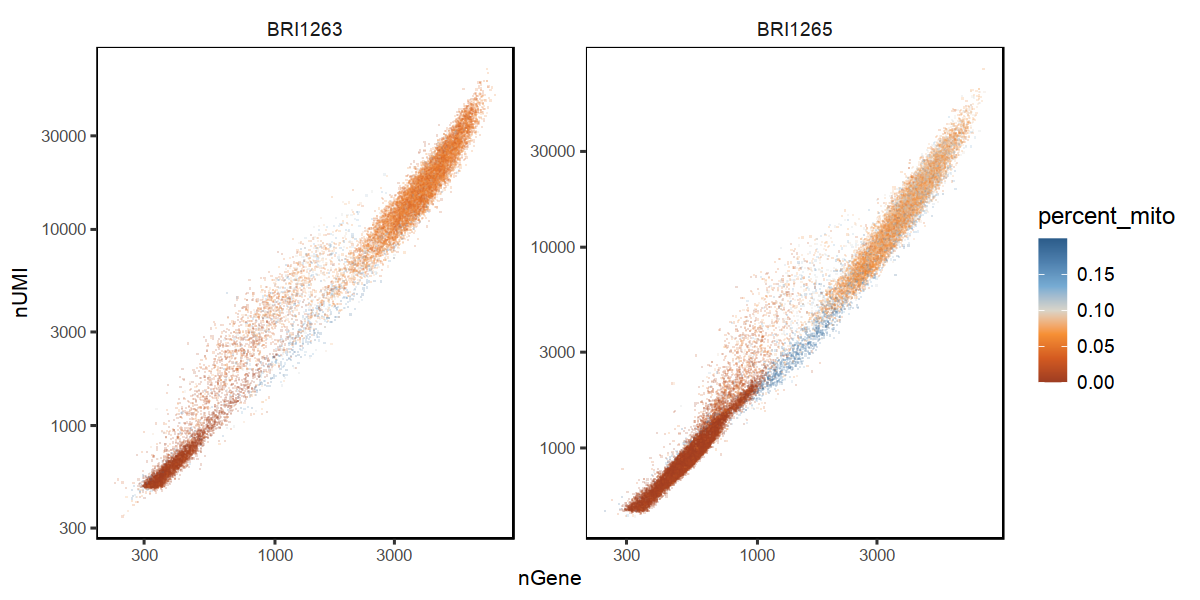

In [34]:
fig.size(5, 10)
meta_data %>% 
    subset(percent_mito < .2) %>% 
    dplyr::sample_frac(1L) %>% 
    ggplot(aes(nGene, nUMI, color = percent_mito)) + 
        geom_point(shape = '.', alpha = .2) + 
        scale_x_log10() + scale_y_log10() + 
        facet_wrap(~LibraryID, scales = 'free') + 
        scale_color_gradient2_tableau() + 
        NULL


Picking joint bandwidth of 0.031



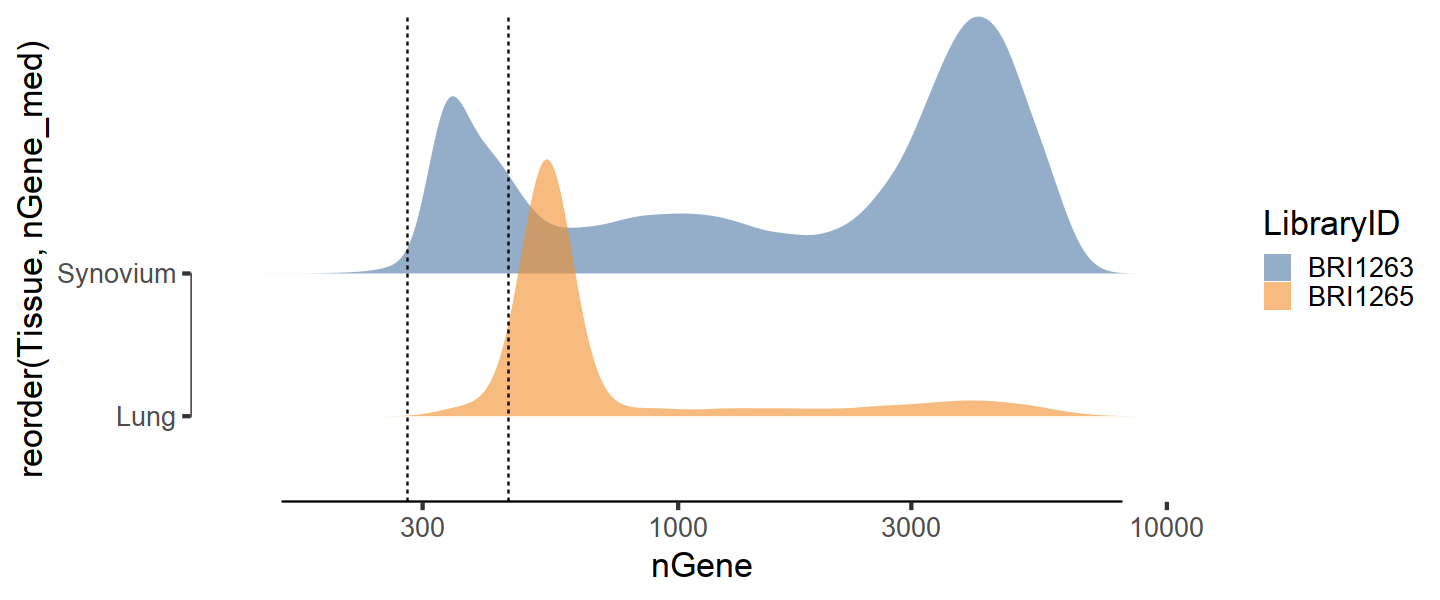

In [25]:
fig.size(5, 12)
data.table(meta_data)[
    , nGene_med := median(nGene), by = LibraryID
][] %>% 
    ggplot(aes(nGene, reorder(Tissue, nGene_med), fill = LibraryID)) + 
        geom_density_ridges2(aes(height = ..ndensity..), alpha = .6, color = NA) + 
        theme_tufte(base_size = 20) + geom_rangeframe(color = 'black') + 
        scale_x_continuous(trans = 'log10') + 
        geom_vline(xintercept = c(280, 450), linetype = 2) + 
        scale_fill_tableau() + 
#         facet_wrap(~scDblFinder.class, ncol = 2) + 
        NULL


In [46]:
meta_data <- meta_data %>% 
    subset(percent_mito < .2 & nGene > 1000)
counts <- counts[, meta_data$CellID]

## Demux 

- Attach the barcode counts to metadata rather than counts. 
- For now, we're cheating and using cellranger's barcodes because I didn't put barcodes in the kallisto reference 


In [83]:
foo <- function(LibraryID) {
    .x <- gsub('BRI', 'BRI-', LibraryID)
    dir <- glue('/data/srlab/bwh10x/210624_A00873_0376_BHC3KTDSX2_KW9079/cellranger-6.0.1/GRCh38/{.x}_hashing/outs/raw_feature_bc_matrix/')
    vars <- fread(glue('{dir}/features.tsv.gz'), header = FALSE)
    mm <- Matrix::readMM(glue('{dir}/matrix.mtx.gz'))
    barcodes <- fread(glue('{dir}/barcodes.tsv.gz'), header = FALSE)    
    barcodes <- gsub('-1', glue('_{LibraryID}'), barcodes$V1)
    rownames(mm) <- vars$V1
    colnames(mm) <- barcodes    
    vars_keep <- subset(vars, V3 == 'Antibody Capture')$V1
    mm <- mm[vars_keep, intersect(barcodes, colnames(counts))]
    return(as.matrix(t(mm)))    
}


In [ ]:
hashtags_fls <- foo('BRI1263')
hashtags_lung <- foo('BRI1265')
hashtags_mat <- rbind(hashtags_lung, hashtags_fls)[meta_data$CellID, ]

In [89]:
meta_data <- meta_data %>% 
    cbind(
        hashtag_argmax = colnames(hashtags_mat)[apply(hashtags_mat, 1, which.max)],
        hashtag_counts = apply(hashtags_mat, 1, max),
        hashtag_total = rowSums(hashtags_mat)
    ) 

In [90]:
head(meta_data)

CellID                   LibraryID nGene nUMI 
AAACCCAAGAGTCTTC_BRI1263 AAACCCAAGAGTCTTC_BRI1263 BRI1263   3172  12876
AAACCCAAGCATCTTG_BRI1263 AAACCCAAGCATCTTG_BRI1263 BRI1263   4484  21732
AAACCCAAGCCTCATA_BRI1263 AAACCCAAGCCTCATA_BRI1263 BRI1263   2118   6126
AAACCCAAGTACCATC_BRI1263 AAACCCAAGTACCATC_BRI1263 BRI1263   4832  25636
AAACCCACAACCGCTG_BRI1263 AAACCCACAACCGCTG_BRI1263 BRI1263   3004  12584
AAACCCACACATTACG_BRI1263 AAACCCACACATTACG_BRI1263 BRI1263   3423  13011
                         percent_mito Tissue   hashtag_argmax hashtag_counts
AAACCCAAGAGTCTTC_BRI1263 0.04729730   Synovium Hashtag3       4027          
AAACCCAAGCATCTTG_BRI1263 0.03510952   Synovium Hashtag3       1590          
AAACCCAAGCCTCATA_BRI1263 0.02742409   Synovium Hashtag9        423          
AAACCCAAGTACCATC_BRI1263 0.07668903   Synovium Hashtag5       1130          
AAACCCACAACCGCTG_BRI1263 0.06102988   Synovium Hashtag7       1589          
AAACCCACACATTACG_BRI1263 0.04749827   Synovium Hashtag3       2283          
                         hashtag_total
AAACCCAAGAGTCTTC_BRI1263 4112         
AAACCCAAGCATCTTG_BRI1263 1696         
AAACCCAAGCCTCATA_BRI1263  437         
AAACCCAAGTACCATC_BRI1263 1178         
AAACCCACAACCGCTG_BRI1263 1647         
AAACCCACACATTACG_BRI1263 2349

## Doublets? 

Let's detect doublets by Hashtags. Each cell needs to have at least 50% of ADTs from main hashtag. 


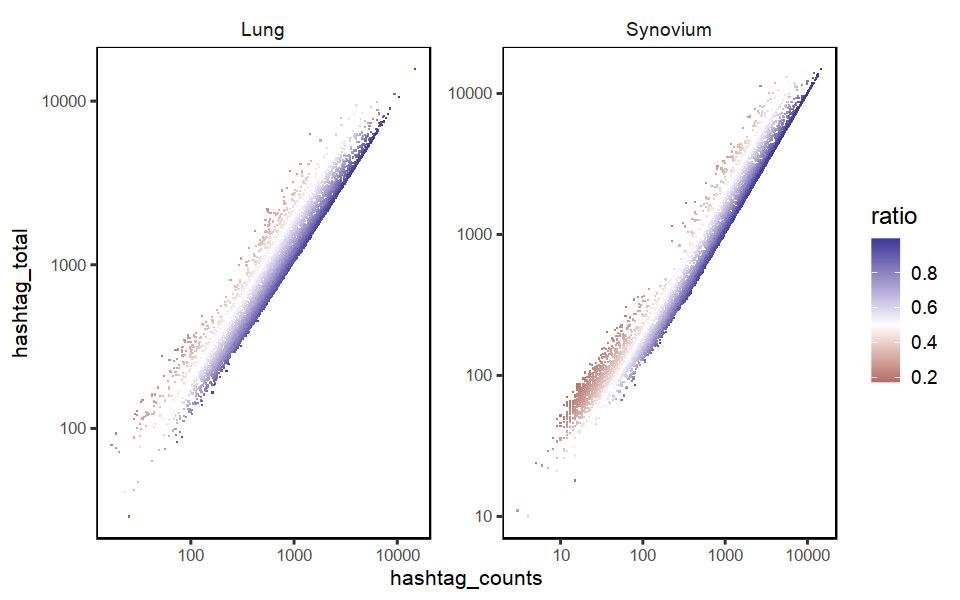

In [140]:
fig.size(5, 8)
meta_data %>% 
    ggplot(aes(hashtag_counts, hashtag_total)) + 
        geom_point(aes(color = hashtag_counts / hashtag_total), shape = '.') + 
        facet_wrap(~Tissue, scales = 'free') + 
        scale_x_log10() + scale_y_log10() +  
        scale_color_gradient2(midpoint = .5) + 
        labs(color = 'ratio') + 
        NULL

In [142]:
# meta_data %>% 
#     dplyr::mutate(keep = hashtag_counts / hashtag_total > .5) %>% 
#     with(table(DonorID, Condition, keep))

# meta_data %>% 
#     subset(hashtag_counts / hashtag_total > .5) %>% 
#     with(table(Tissue, Condition))

In [146]:
meta_data <- meta_data %>% 
    subset(hashtag_counts / hashtag_total > .5) 


In [148]:
counts <- counts[, meta_data$CellID]

## Cache

In [149]:
## Sanity check 
all(colnames(counts) == meta_data$CellID)

[1] TRUE

In [150]:
saveRDS(counts, '/data/srlab/ik936/Roche/data/cache/revision1_stim_counts.rds')
saveRDS(meta_data, '/data/srlab/ik936/Roche/data/cache/revision1_stim_meta.rds')

# Integrated analysis

## Load

In [7]:
counts <- readRDS('/data/srlab/ik936/Roche/data/cache/revision1_stim_counts.rds')
meta_data <- readRDS('/data/srlab/ik936/Roche/data/cache/revision1_stim_meta.rds')

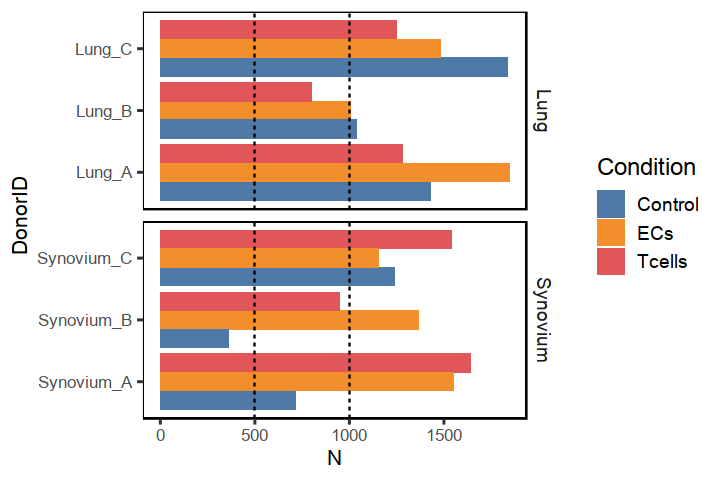

In [8]:
fig.size(4, 6)
data.table(meta_data)[, .N, by = .(Condition, DonorID, Tissue)] %>% 
    ggplot(aes(DonorID, N, fill = Condition)) + 
        geom_bar(stat = 'identity', position = position_dodge()) + 
        facet_grid(Tissue~., scales = 'free') + 
        coord_flip() + 
#         scale_y_log10() + 
        scale_fill_tableau() + 
        geom_hline(yintercept = c(500, 1e3), linetype = 2) + 
        NULL

## PCA 

In [9]:
obj <- create_object(counts, meta_data, do_qc = FALSE)


Warning message in create_object(counts, meta_data, do_qc = FALSE):
“weights not initialized in metadata. Setting all to 1.”
start normalization

start vargenes

start pca



In [10]:
names(obj)

[1] "meta_data"          "exprs_raw"          "exprs_norm"        
[4] "var_genes"          "V"                  "loadings"          
[7] "vargenes_means_sds"

In [11]:
obj$U <- do_umap(obj$V, .spread = 1.0, .min_dist = 0.3)

In [12]:
head(obj$meta_data)

CellID                   LibraryID nGene nUMI  percent_mito Tissue  
1 AAACCCAAGAGTCTTC_BRI1263 BRI1263   3172  12876 0.04729730   Synovium
2 AAACCCAAGCATCTTG_BRI1263 BRI1263   4484  21732 0.03510952   Synovium
3 AAACCCAAGCCTCATA_BRI1263 BRI1263   2118   6126 0.02742409   Synovium
4 AAACCCAAGTACCATC_BRI1263 BRI1263   4832  25636 0.07668903   Synovium
5 AAACCCACAACCGCTG_BRI1263 BRI1263   3004  12584 0.06102988   Synovium
6 AAACCCACACATTACG_BRI1263 BRI1263   3423  13011 0.04749827   Synovium
  hashtag_argmax hashtag_counts hashtag_total Condition DonorID    weight
1 Hashtag3       4027           4112          Control   Synovium_C 1     
2 Hashtag3       1590           1696          Control   Synovium_C 1     
3 Hashtag9        423            437          Tcells    Synovium_C 1     
4 Hashtag5       1130           1178          ECs       Synovium_B 1     
5 Hashtag7       1589           1647          Tcells    Synovium_A 1     
6 Hashtag3       2283           2349          Control   Synovium_C 1

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


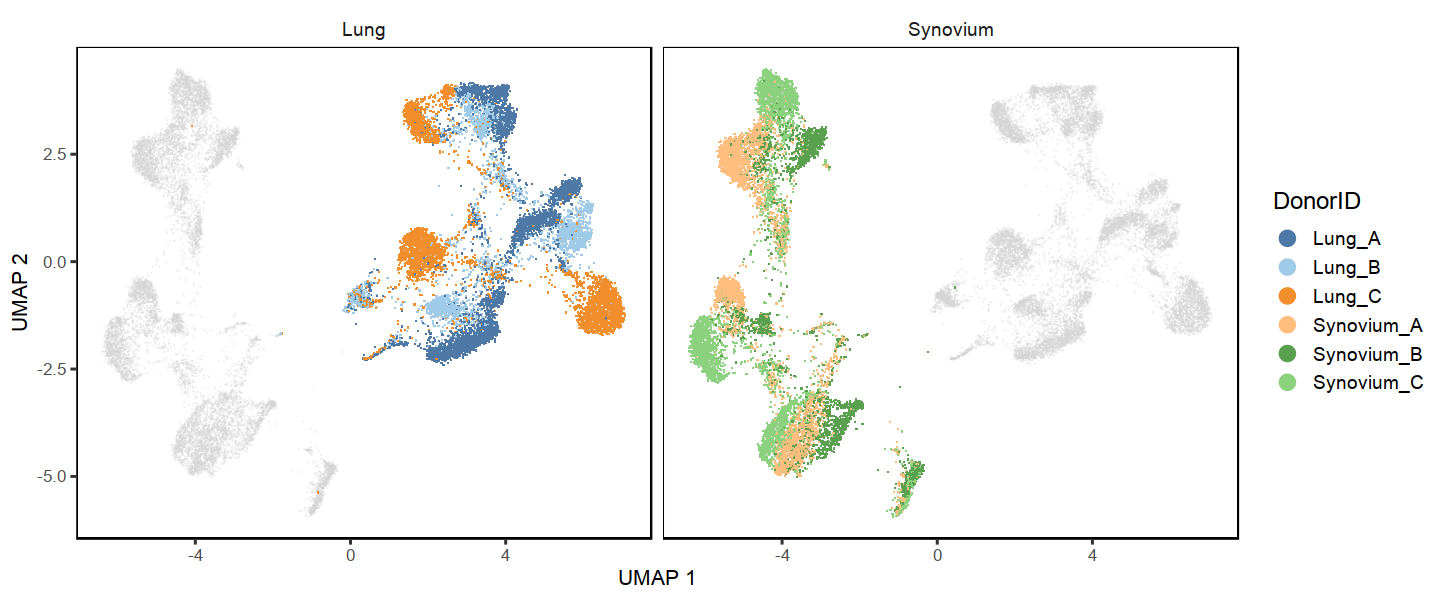

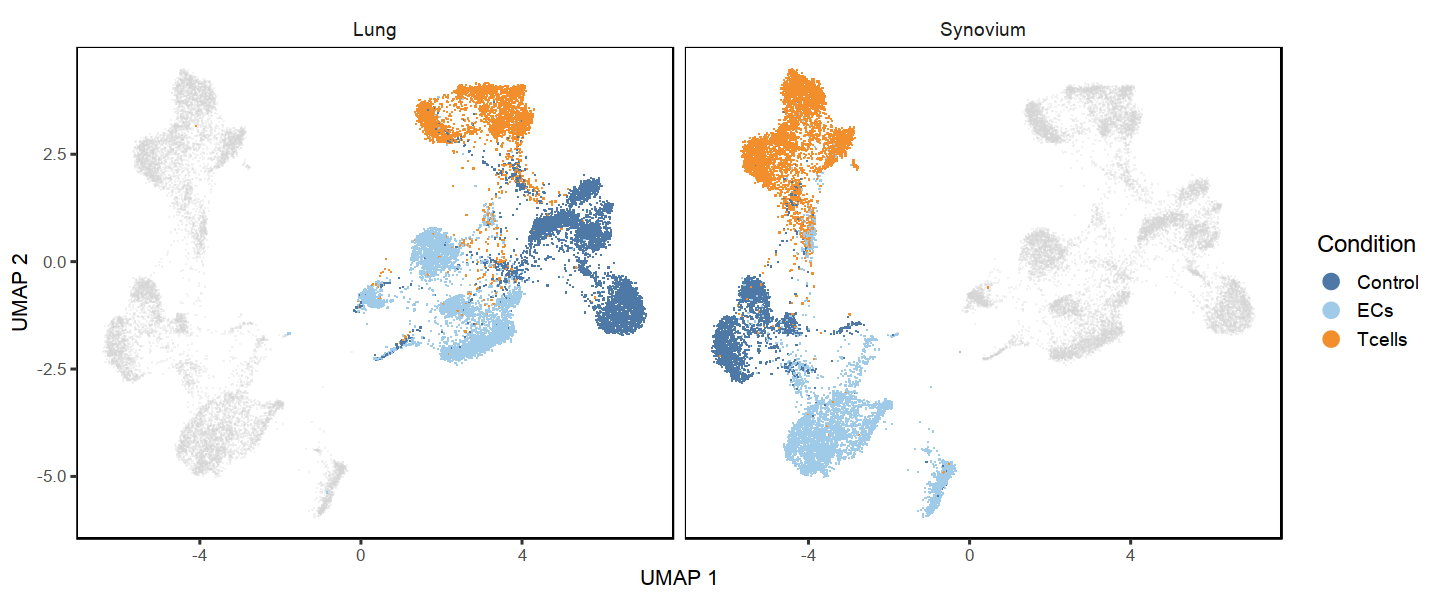

In [13]:
fig.size(5, 12)
do_scatter(obj$U$embedding, obj$meta_data, 'DonorID', quo(Tissue), do_labels = FALSE, no_guides = FALSE) 
do_scatter(obj$U$embedding, obj$meta_data, 'Condition', quo(Tissue), do_labels = FALSE, no_guides = FALSE) 
# do_scatter(obj$U$embedding, obj$meta_data, 'hashtag_argmax', quo(Tissue), do_labels = FALSE, no_guides = FALSE) 


## Cluster

In [14]:
obj$adj <- obj$U$adj
suppressWarnings({
    obj <- do_cluster(obj, 'adj', c(.1, .2, .3, .4))
})


Registered S3 method overwritten by 'pryr':
  method      from
  print.bytes Rcpp

0.1

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

0.2

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

0.3

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

0.4

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

New names:
* NA -> ...1
* NA -> ...2
* NA -> ...3
* NA -> ...4

finished Louvain



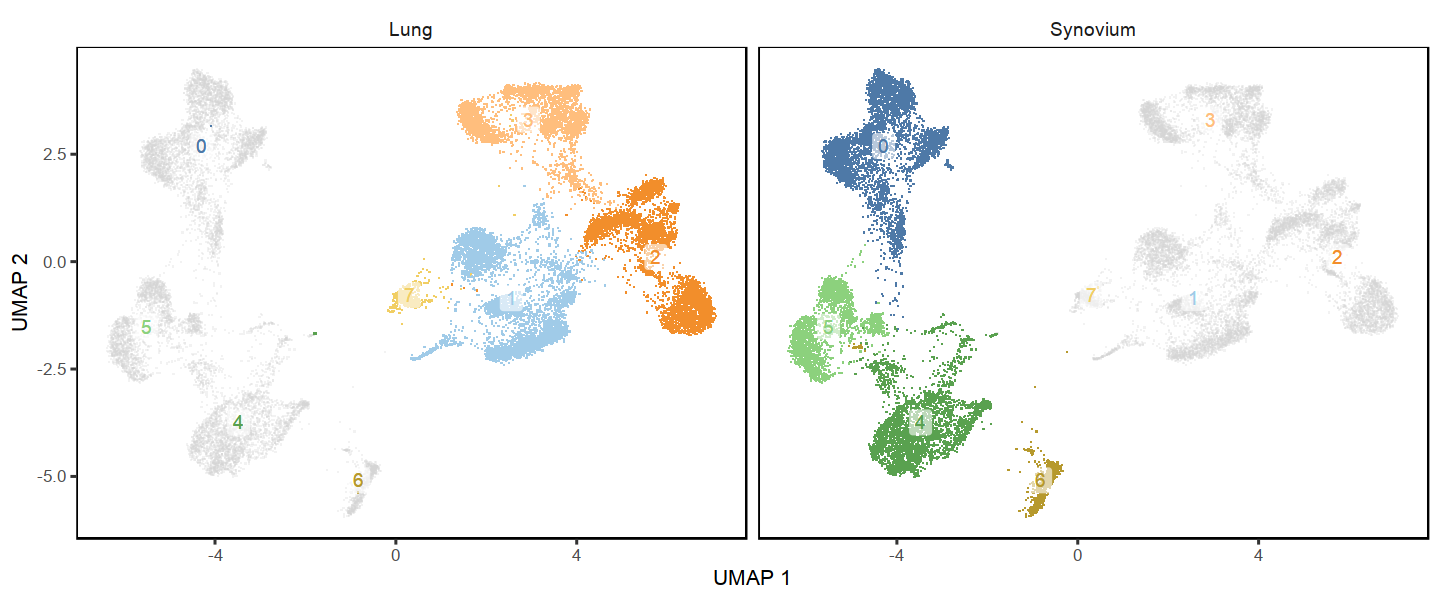

In [15]:
fig.size(5, 12)
suppressWarnings({
    do_scatter(obj$U$embedding, cbind(obj$meta_data, obj$clusters_df), 'res1', quo(Tissue))     
})


In [16]:
obj$markers0 <- wilcoxauc(obj$exprs_norm, obj$clusters_df$res1)

In [17]:
presto::top_markers(obj$markers0)

rank 0       1      2       3      4        5        6        7       
1   1   IFI6    HMGA1  DCN     HLA-C  LDHA     ITGA11   UBA52    S100A6  
2   2   WARS1   FKBP5  FTL     IL32   SERPINE1 MFAP5    TSPO     LGALS1  
3   3   TNFAIP6 TXNRD1 MFAP4   TAPBP  COL6A3   EFEMP1   LGALS1   ATP5F1E 
4   4   CCL5    F2R    NR2F1   GBP2   NDUFA4L2 IGFBP3   ATP5F1E  UBA52   
5   5   TNFAIP2 LTBP1  QSOX1   HLA-B  ENO1     SERPINE2 S100A11  PFDN5   
6   6   BST2    NAP1L1 CAMK2N1 FST    COL6A2   CCDC80   SH3BGRL3 POLR2L  
7   7   SLC39A8 EBPL   CXCL12  PARP14 ITGA5    HTRA1    VIM      FAU     
8   8   IFI27   GLUL   PTN     GBP1   COL6A1   COL12A1  TPM2     TPM2    
9   9   SOD2    ETFB   FGF7    B2M    EPS8     CEMIP    TMSB4X   TMSB10  
10 10   CXCL11  TRNP1  MYLK    CCL2   CAV1     CRLF1    SERF2    SH3BGRL3

In [18]:
## Check for contaminating clusters 
obj$markers0 %>% 
    subset(auc > .6) %>% 
    subset(feature %in% c('KRT18', 'VWF', 'ACKR1', 'PTPRC', 'CD3E'))

feature group avgExpr logFC statistic auc pval padj pct_in pct_out

In [19]:
## Look for key markers
obj$markers0 %>% 
    subset(auc > .6) %>% 
    subset(feature %in% c('CXCL11', 'CXCL10', 'CXCL9', 'CCL19', 'CCL21')) 

feature group avgExpr  logFC     statistic auc       pval        
3614   CXCL10  0     5.303806 2.5467601 74080122  0.9357683 0.000000e+00
3615   CXCL11  0     3.872130 2.4030411 74676464  0.9433012 0.000000e+00
3625   CXCL9   0     4.811058 2.3964311 72398135  0.9145217 0.000000e+00
53528  CXCL10  3     4.938135 1.9774508 53262807  0.8378327 0.000000e+00
53529  CXCL11  3     3.204752 1.4876599 51220922  0.8057135 0.000000e+00
53539  CXCL9   3     4.578420 1.9914863 54167224  0.8520593 0.000000e+00
120080 CXCL10  7     3.484647 0.2380930  7672663  0.6012178 6.524385e-17
120091 CXCL9   7     3.166163 0.2927032  7809684  0.6119545 2.427311e-20
       padj         pct_in    pct_out 
3614   0.000000e+00 100.00000 99.60771
3615   0.000000e+00  99.88569 88.85574
3625   0.000000e+00  99.95428 98.59108
53528  0.000000e+00 100.00000 99.62932
53529  0.000000e+00  99.51793 89.52699
53539  0.000000e+00 100.00000 98.65824
120080 1.692962e-16 100.00000 99.67565
120091 7.219450e-20  99.82847 98.83052

In [20]:
## Look for key markers
obj$markers0 %>% 
    subset(auc > .7) %>% 
    subset(feature %in% c('COL3A1', 'SPARC', 'POSTN', 'NOTCH3')) 

feature group avgExpr   logFC     statistic auc       pval         
36531  COL3A1  2     2.8777859 0.8895793 56336886  0.7946200  0.000000e+00
75973  NOTCH3  4     0.7670167 0.6550413 50913174  0.8257414  0.000000e+00
79945  SPARC   4     3.6014054 1.3816646 54602074  0.8855703  0.000000e+00
94039  POSTN   5     1.8994281 0.8766141 31298846  0.7028980 5.247501e-227
96583  SPARC   5     3.3350699 1.0181410 35857357  0.8052713  0.000000e+00
113221 SPARC   6     3.2676027 0.8804094 11823188  0.7294508 4.123675e-101
       padj          pct_in    pct_out 
36531   0.000000e+00  99.18335 92.83075
75973   0.000000e+00  75.77368 15.34710
79945   0.000000e+00 100.00000 93.62353
94039  2.711426e-225  84.74499 59.76229
96583   0.000000e+00  99.86339 93.95374
113221  1.025556e-99  96.78284 94.45391

## Harmony

use_weights



[1] FALSE


use_weights

use_weights



[1] FALSE


use_weights

Harmony 1/5

Harmony 2/5

Harmony 3/5

Harmony 4/5

Harmony 5/5



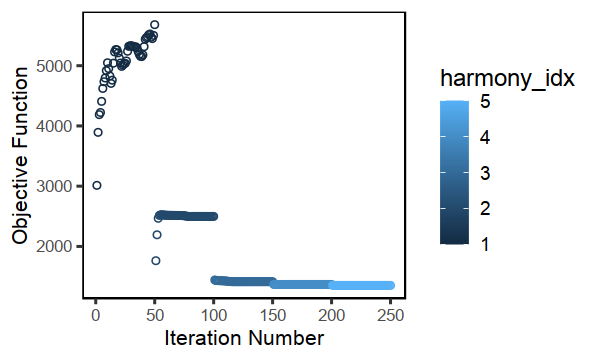

In [21]:
fig.size(3, 5)
obj <- do_harmony(
    obj, c('DonorID', 'Tissue'), theta=c(0, .5), 
    max.iter.harmony=5, max.iter.cluster=50,
    epsilon.cluster = -Inf, epsilon.harmony = -Inf, 
    plot_convergence = TRUE
) 

obj$Uh <- do_umap(t(obj$Z_corr), .spread = 1.2, .min_dist = 0.5)

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


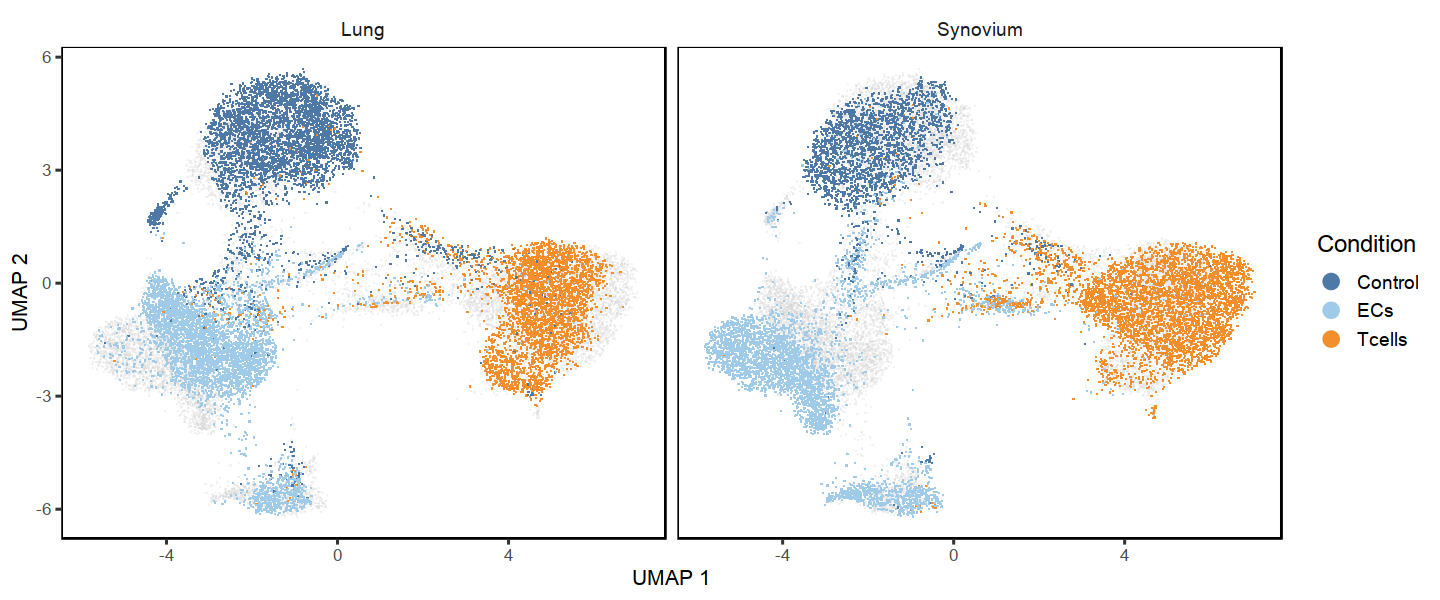

In [22]:
fig.size(5, 12)
# do_scatter(obj$Uh$embedding, obj$meta_data, 'DonorID', quo(Tissue), do_labels = FALSE, no_guides = FALSE) 
do_scatter(obj$Uh$embedding, obj$meta_data, 'Condition', quo(Tissue), do_labels = FALSE, no_guides = FALSE) 


## Plot Genes

In [23]:
genes_plot <- c('THY1', 'NOTCH3', 'GGT5', 'COL3A1', 'POSTN', 'SPARC')

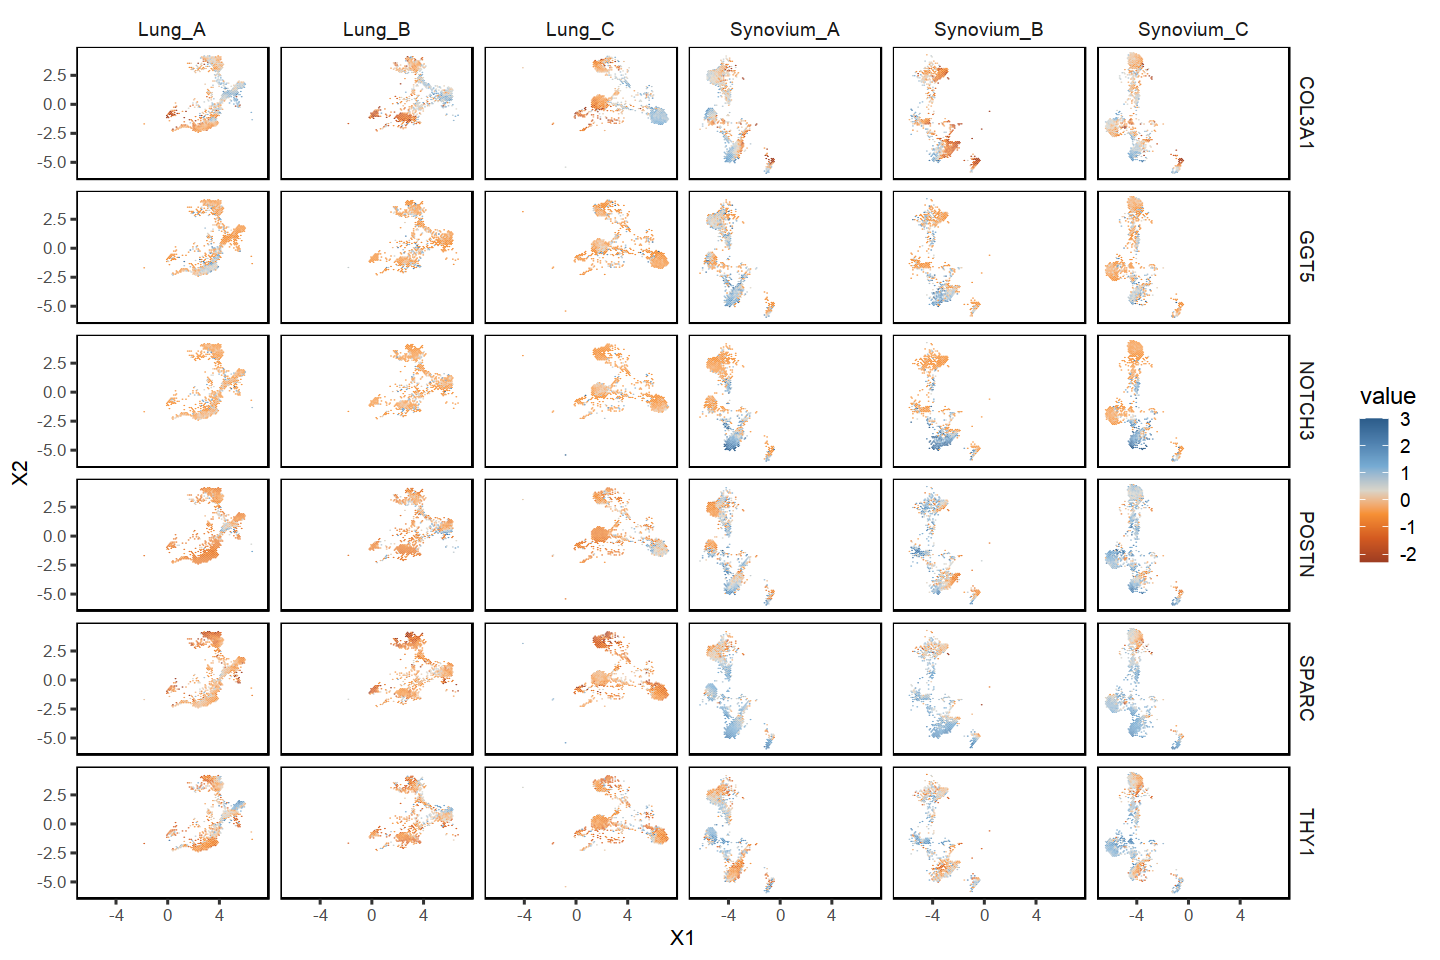

In [24]:
fig.size(8, 12)
obj$U$embedding %>% 
    cbind(obj$meta_data) %>% 
    cbind(t(scaleData(obj$exprs_norm[genes_plot, ], thresh = 3))) %>% 
    data.frame() %>% 
    tidyr::gather(key, val, one_of(genes_plot)) %>% 
    ggplot(aes(X1, X2, z = val))  + 
        stat_summary_hex(fun = 'mean', bins = 100) + 
        facet_grid(key~DonorID) + 
#         facet_grid(Tissue~key) + 
        scale_fill_gradient2_tableau() + 
        NULL
    

$Lung

$Synovium


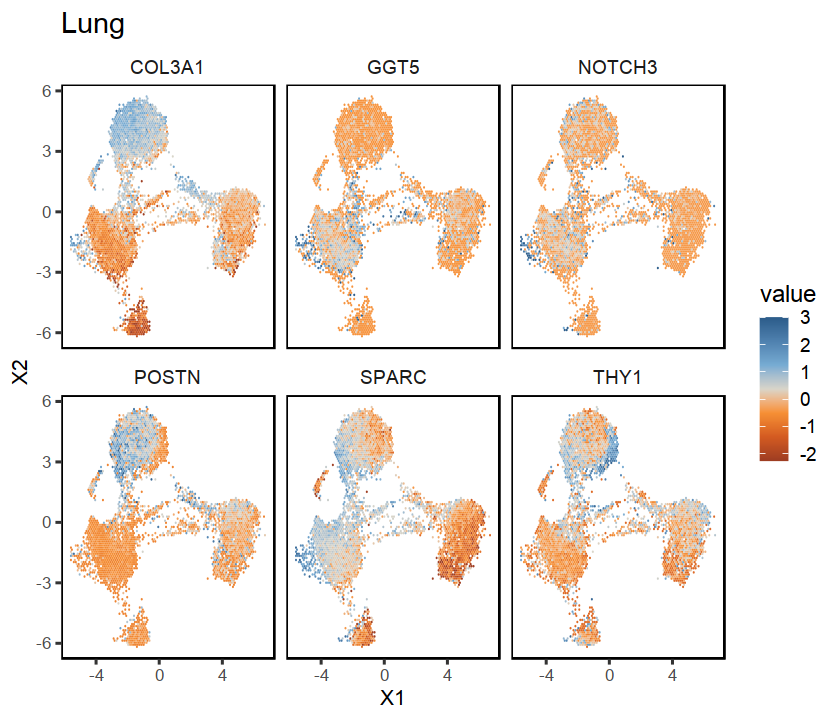

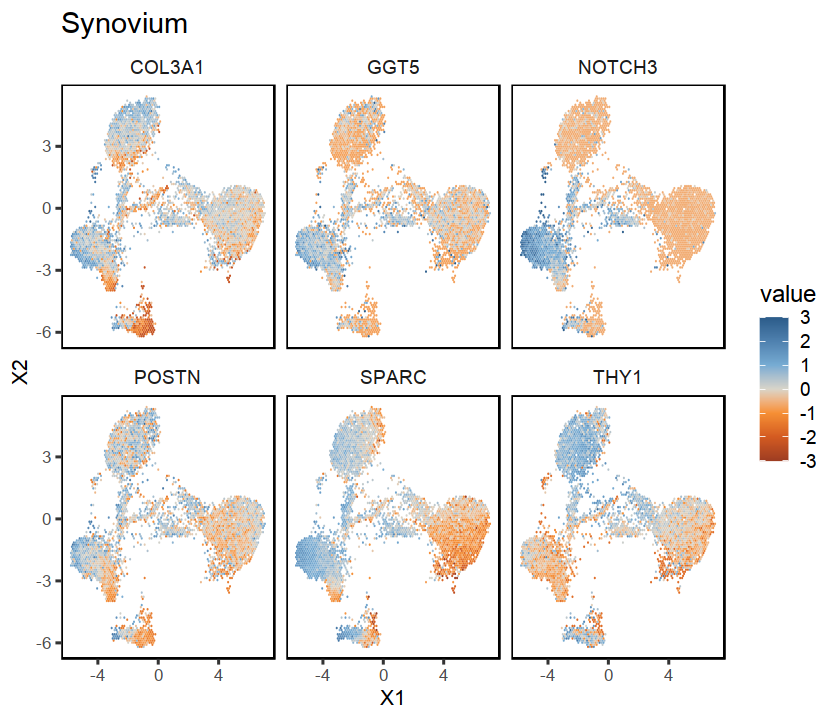

In [25]:
fig.size(6, 7)
obj$Uh$embedding %>% 
    cbind(obj$meta_data) %>% 
#     cbind(t(scaleData(obj$exprs_norm[genes_plot, ], thresh = 3))) %>% 
    cbind(as.matrix(t(obj$exprs_norm[genes_plot, ]))) %>% 
    data.frame() %>% 
    tidyr::gather(key, val, one_of(genes_plot)) %>% 
    split(.$Tissue) %>% imap(function(.SD, .tissue) {
        .SD <- data.table(.SD)[, val := scale(val) %>% pmax(-3) %>% pmin(3), by = key][]
        ggplot(.SD, aes(X1, X2, z = val))  + 
            stat_summary_hex(fun = 'mean', bins = 100) + 
            facet_wrap(~key) + 
            scale_fill_gradient2_tableau() + 
            labs(title = .tissue) + 
            NULL   
    });


## Cluster post Harmony

In [26]:
obj$adj <- obj$Uh$adj
suppressWarnings({
    suppressMessages({
        obj <- do_cluster(obj, 'adj', c(.1, .2, .3, .4))        
    })
})


In [27]:
apply(obj$clusters_df, 2, table)

$res1

   0    1    2    3    4 
7838 6827 5990 1334  484 

$res2

   0    1    2    3    4    5    6 
6766 6747 5757 1337 1102  536  228 

$res3

   0    1    2    3    4    5    6 
6767 6745 5762 1339 1105  532  223 

$res4

   0    1    2    3    4    5    6    7    8 
5991 5857 5732 1339 1131  854  776  557  236 


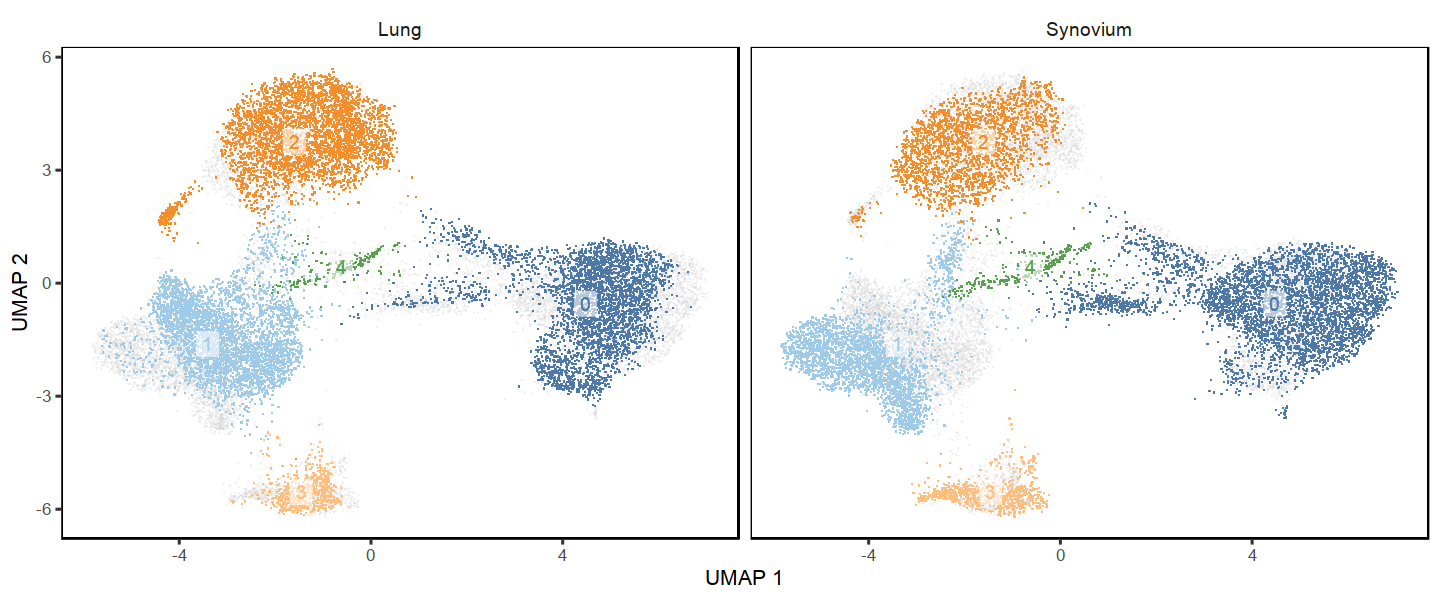

In [28]:
fig.size(5, 12)
suppressWarnings({
    do_scatter(obj$Uh$embedding, cbind(obj$meta_data, obj$clusters_df), 'res1', quo(Tissue))     
})


In [29]:
obj$markers0 <- wilcoxauc(obj$exprs_norm, obj$clusters_df$res1)

In [30]:
presto::top_markers(obj$markers0)

rank 0       1      2         3        4    
1   1   GBP1    CAV1   FTL       UBA52    H2AZ1
2   2   SOD2    FN1    CXCL12    LGALS1   CENPF
3   3   CXCL10  GAPDH  FGF7      ATP5F1E  STMN1
4   4   WARS1   DNAJB4 DAB2      SH3BGRL3 HMGB1
5   5   TNFAIP6 HMGA1  TIMP3     FAU      PCLAF
6   6   IL32    FKBP5  SOX4      TPM2     PTTG1
7   7   PARP14  MYC    PMP22     S100A11  BIRC5
8   8   CXCL9   EEF2   LRP1      S100A6   HMGN2
9   9   ISG15   ANXA2  TNFRSF11B EEF1B2   TPX2 
10 10   IRF1    RBM3   FHL1      NDUFA4   MKI67

In [31]:
## Look for key markers
obj$markers0 %>% 
    subset(auc > .6) %>% 
    subset(feature %in% c('CXCL11', 'CXCL10', 'CXCL9', 'CCL19', 'CCL21')) 

feature group avgExpr  logFC    statistic auc       pval padj pct_in   
3614 CXCL10  0     5.125482 2.875732 113870271 0.9926871 0    0    100.00000
3615 CXCL11  0     3.560473 2.493254 112291822 0.9789266 0    0     99.66828
3625 CXCL9   0     4.694332 2.784409 113183584 0.9867007 0    0     99.97448
     pct_out 
3614 99.51486
3615 86.36146
3625 98.25760

In [32]:
# ## Look for key markers
# obj$markers0 %>% 
# #     subset(auc > .7) %>% 
#     subset(feature %in% c('COL3A1', 'SPARC', 'POSTN', 'NOTCH3')) %>% 
#     arrange(-auc)

## Cache

In [33]:
saveRDS(obj, '/data/srlab/ik936/Roche/data/cache/revision1_stim_object.rds')

# Within tissue analyses

In [34]:
counts <- readRDS('/data/srlab/ik936/Roche/data/cache/revision1_stim_counts.rds')
meta_data <- readRDS('/data/srlab/ik936/Roche/data/cache/revision1_stim_meta.rds')

## Synovium

### PCA, harmony, etc. 

Warning message in create_object(counts[, subset(meta_data, Tissue == "Synovium")$CellID], :
“weights not initialized in metadata. Setting all to 1.”
start normalization

start vargenes

start pca

use_weights



[1] FALSE


use_weights

use_weights



[1] FALSE


use_weights

Harmony 1/5

Harmony 2/5

Harmony 3/5

Harmony 4/5

Harmony 5/5



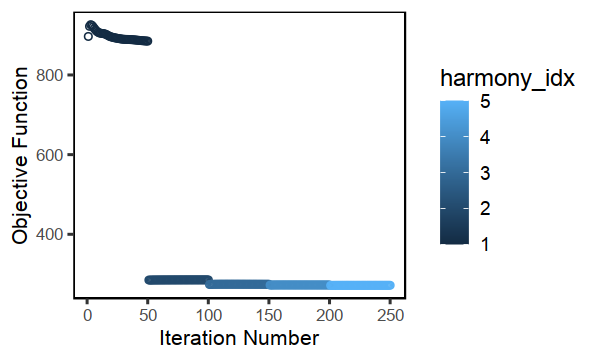

In [35]:
fls <- create_object(
    counts[, subset(meta_data, Tissue == 'Synovium')$CellID], 
    subset(meta_data, Tissue == 'Synovium'),
    do_qc = FALSE
)


fls$U <- do_umap(fls$V, .spread = 1.0, .min_dist = 0.3)

fig.size(3, 5)
fls <- do_harmony(
    fls, c('DonorID'), theta=c(0), 
    max.iter.harmony=5, max.iter.cluster=50,
    epsilon.cluster = -Inf, epsilon.harmony = -Inf, 
    plot_convergence = TRUE
) 

fls$Uh <- do_umap(t(fls$Z_corr), .spread = 1.2, .min_dist = 0.5)

fls$adj <- fls$Uh$adj
suppressWarnings({
    suppressMessages({
        fls <- do_cluster(fls, 'adj', c(.1, .2, .3, .4))        
    })
})


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


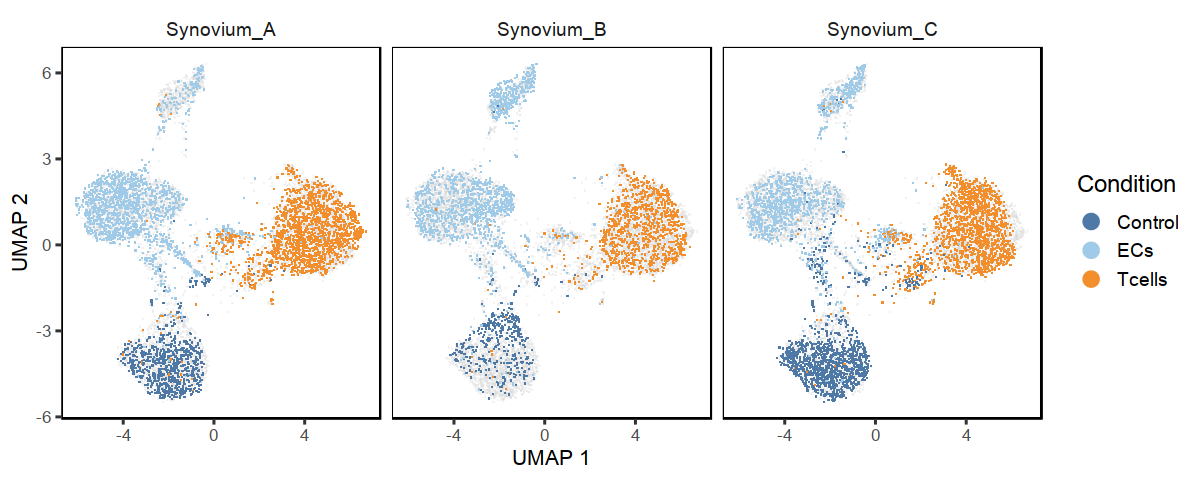

In [36]:
fig.size(4, 10)
do_scatter(fls$Uh$embedding, fls$meta_data, 'Condition', quo(DonorID), do_labels=FALSE, no_guides=FALSE)

### Plot genes

In [103]:
# genes_plot <- c('THY1', 'NOTCH3', 'GGT5', 'COL3A1', 'POSTN', 'SPARC', 'ADAM12', 'CTHRC1', 'COL1A1')

In [102]:
# fig.size(9, 10)
# fls$Uh$embedding %>% 
#     cbind(fls$meta_data) %>% 
#     cbind(t(scaleData(fls$exprs_norm[genes_plot, ], thresh = 3))) %>% 
#     data.frame() %>% 
#     tidyr::gather(key, val, one_of(genes_plot)) %>% 
#     ggplot(aes(X1, X2, z = val))  + 
#         stat_summary_hex(fun = 'mean', bins = 100) + 
#         facet_grid(key~DonorID) + 
#         scale_fill_gradient2_tableau() + 
#         NULL
    

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


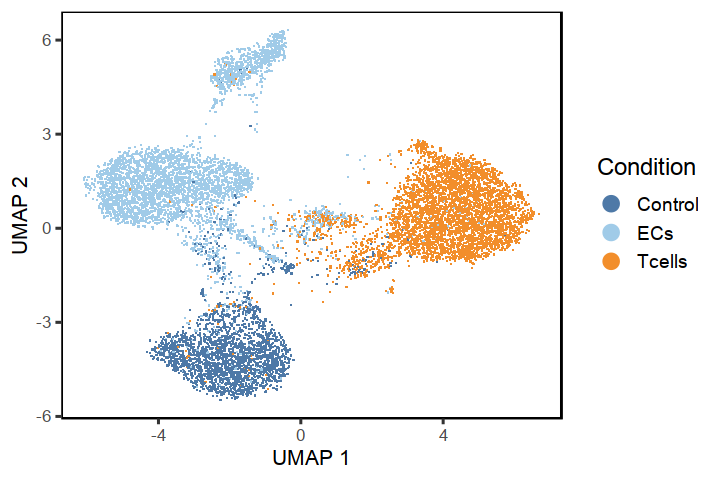

In [95]:
fig.size(4, 6)
# idx <- which(fls$umap_harmony[, 1] < 3)
p1 <- do_scatter(fls$Uh$embedding, fls$meta_data, 'Condition', do_labels = FALSE, no_guides = FALSE)
p1

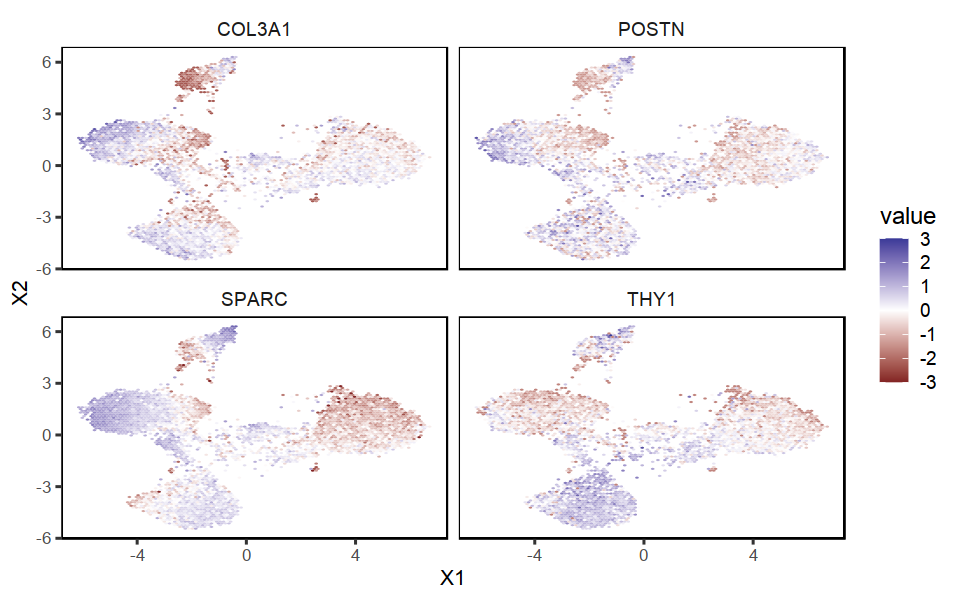

In [99]:
fig.size(5, 8)
genes_plot <- c('THY1', 'COL3A1', 'POSTN', 'SPARC')
p2 <- fls$Uh$embedding %>% 
    cbind(fls$meta_data) %>% 
    cbind(t(scaleData(fls$exprs_norm[genes_plot, ], thresh = 3))) %>% 
    data.frame() %>% 
    tidyr::gather(key, val, one_of(genes_plot)) %>% 
    ggplot(aes(X1, X2, z = val))  + 
        stat_summary_hex(fun = 'mean', bins = 100) + 
        facet_wrap(~key) + 
        scale_fill_gradient2() + 
        NULL
p2

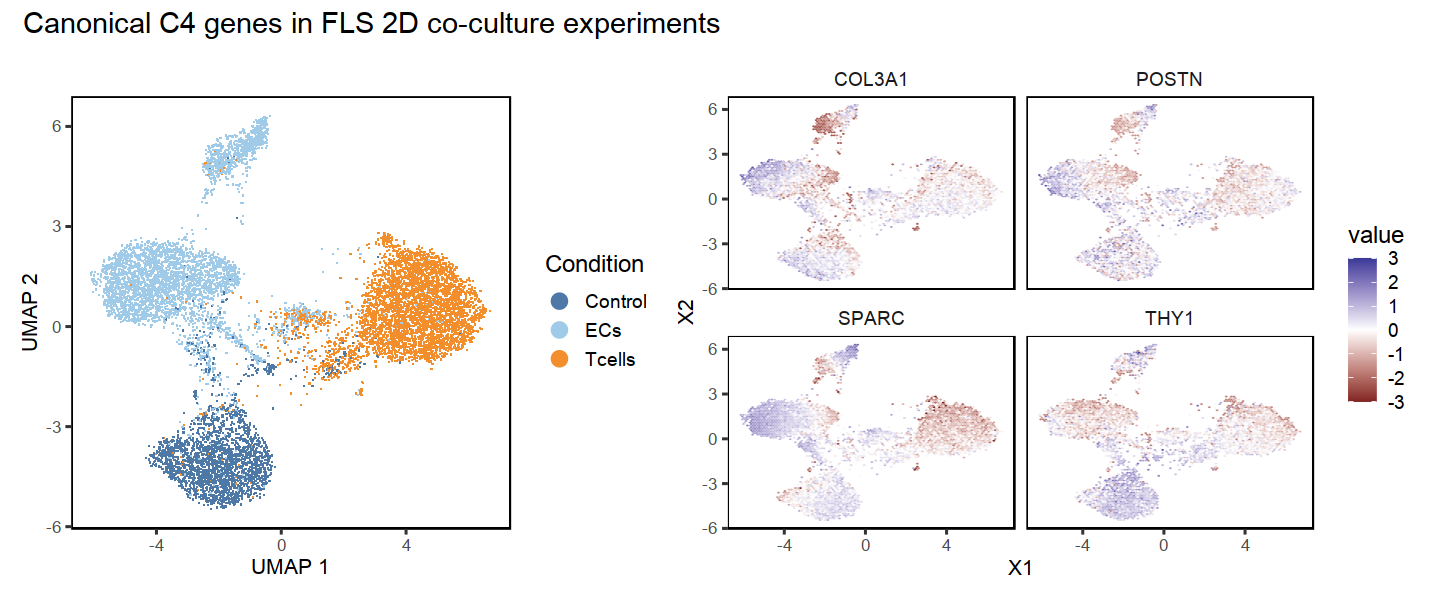

In [104]:
fig.size(5, 12)

(p1 | p2) + plot_layout(widths = c(1.5, 2)) + 
plot_annotation(title = 'Canonical C4 genes in FLS 2D co-culture experiments')

### Enrich signatures

In [39]:
# fls$enrich <- singlecellmethods:::enrich_cells(fls$exprs_norm, gs_fls, mode = 'unweighted')
fls$enrich <- singlecellmethods:::enrich_cells(fls$exprs_norm, gs_fls, mode = 'weighted')$scores


In [40]:
map(gs_fls, length)

$C0
[1] 47

$C1
[1] 6

$C10
[1] 149

$C11
[1] 275

$C12
[1] 34

$C13
[1] 147

$C2
[1] 76

$C3
[1] 262

$C4
[1] 348

$C5
[1] 371

$C6
[1] 237

$C7
[1] 46

$C8
[1] 435

$C9
[1] 386

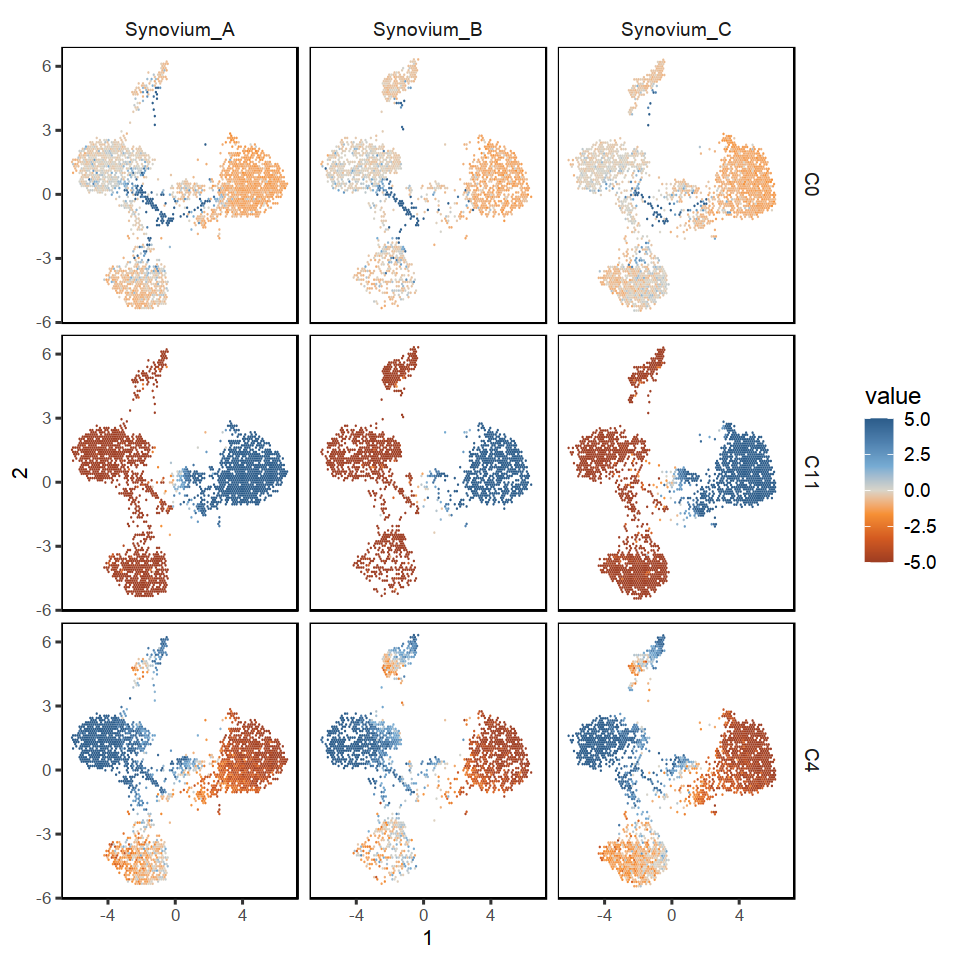

In [41]:
fig.size(8, 8)
fls$Uh$embedding %>% 
    cbind(fls$meta_data) %>% 
#     cbind(scale(fls$enrich)) %>% 
    cbind(fls$enrich) %>% 
    tidyr::gather(key, val, one_of(colnames(fls$enrich))) %>%
    dplyr::mutate(val = pmin(val, 5)) %>% 
    dplyr::mutate(val = pmax(val, -5)) %>% 
    subset(key %in% paste0('C', c(0, 4, 11))) %>% 
    ggplot(aes(`1`, `2`, z = val)) + 
        stat_summary_hex(fun = 'mean', bins = 100) + 
#         facet_wrap(~key) + 
        facet_grid(key~DonorID) + 
        scale_fill_gradient2_tableau() + 
        NULL



### Cache

In [42]:
saveRDS(fls, '/data/srlab/ik936/Roche/data/cache/revision1_stim_object_synovium.rds')

## Lung

### PCA, harmony, etc. 

Warning message in create_object(counts[, subset(meta_data, Tissue == "Lung")$CellID], :
“weights not initialized in metadata. Setting all to 1.”
start normalization

start vargenes

start pca

use_weights



[1] FALSE


use_weights

use_weights



[1] FALSE


use_weights

Harmony 1/5

Harmony 2/5

Harmony 3/5

Harmony 4/5

Harmony 5/5



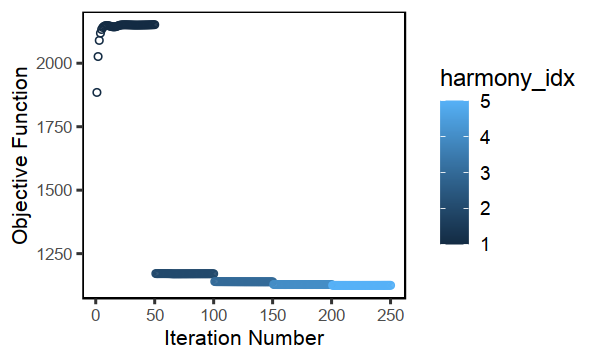

In [43]:
lung <- create_object(
    counts[, subset(meta_data, Tissue == 'Lung')$CellID], 
    subset(meta_data, Tissue == 'Lung'),
    do_qc = FALSE
)

lung$U <- do_umap(lung$V, .spread = 1.0, .min_dist = 0.3)

fig.size(3, 5)
lung <- do_harmony(
    lung, c('DonorID'), theta=c(0), 
    max.iter.harmony=5, max.iter.cluster=50,
    epsilon.cluster = -Inf, epsilon.harmony = -Inf, 
    plot_convergence = TRUE
) 

lung$Uh <- do_umap(t(lung$Z_corr), .spread = 1.2, .min_dist = 0.5)

lung$adj <- lung$Uh$adj
suppressWarnings({
    suppressMessages({
        lung <- do_cluster(lung, 'adj', c(.1, .2, .3, .4))        
    })
})


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


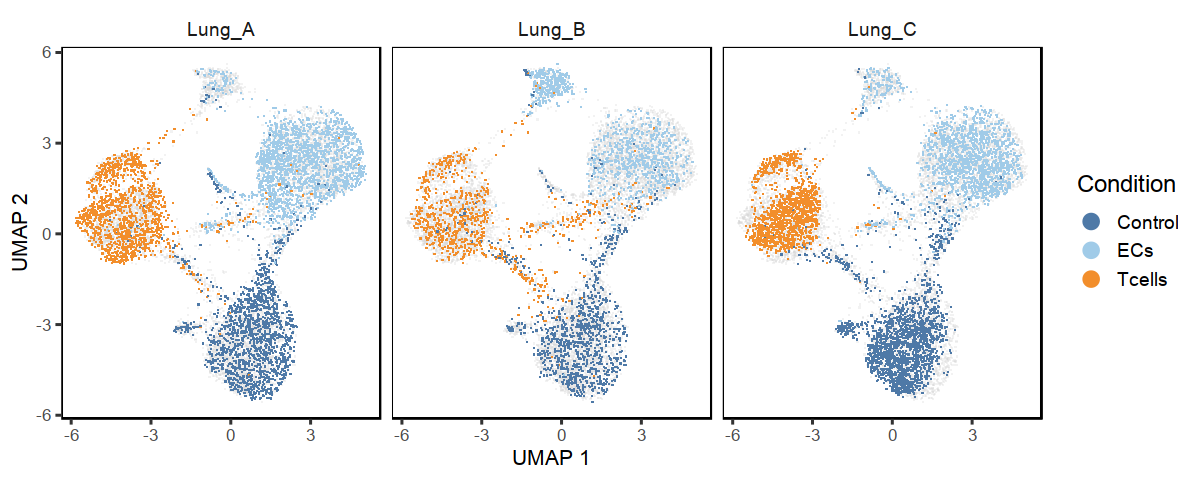

In [44]:
fig.size(4, 10)
do_scatter(lung$Uh$embedding, lung$meta_data, 'Condition', quo(DonorID), do_labels=FALSE, no_guides=FALSE)

### Plot genes

In [106]:
# genes_plot <- c('THY1', 'NOTCH3', 'GGT5', 'COL3A1', 'POSTN', 'SPARC', 'ADAM12', 'CTHRC1', 'COL1A1')
# # genes_plot <- c('THY1', 'NOTCH3', 'GGT5', 'COL')
# # genes_plot <- c('HBQ1', 'IGFBP2', 'ECSCR')

In [105]:
# fig.size(12, 10)
# lung$Uh$embedding %>% 
#     cbind(lung$meta_data) %>% 
#     cbind(t(scaleData(lung$exprs_norm[genes_plot, ], thresh = 3))) %>% 
#     data.frame() %>% 
#     tidyr::gather(key, val, one_of(genes_plot)) %>% 
#     ggplot(aes(X1, X2, z = val))  + 
#         stat_summary_hex(fun = 'median', bins = 100) + 
# #         facet_grid(key~DonorID) + 
#         facet_wrap(~key) + 
#         scale_fill_gradient2_tableau() + 
#         NULL
    

In [47]:
# fig.size(8, 12)
# lung$meta_data %>% 
#     cbind(as.matrix(t((lung$exprs_norm[genes_plot, ])))) %>% 
#     data.frame() %>% 
#     tidyr::gather(key, val, one_of(genes_plot)) %>% 
#     ggplot(aes(Condition, val, color = DonorID)) + 
#         geom_violin() + 
#         geom_point(shape = '.') + 
#         facet_wrap(~key, scales = 'free_y') + 
#         NULL

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


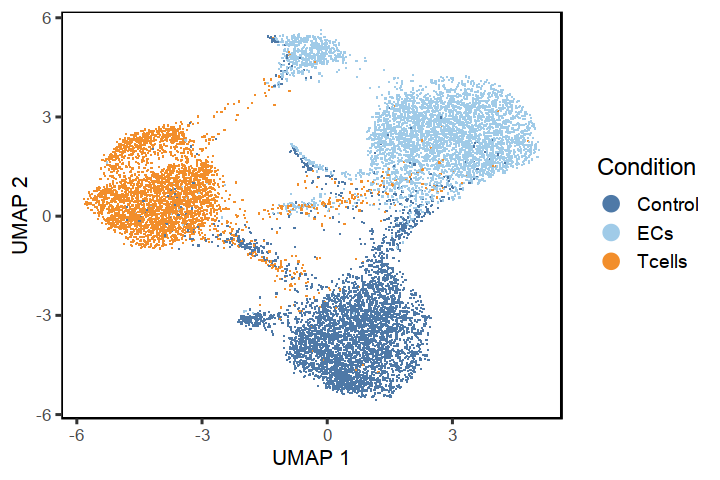

In [107]:
fig.size(4, 6)
# idx <- which(fls$umap_harmony[, 1] < 3)
p1 <- do_scatter(lung$Uh$embedding, lung$meta_data, 'Condition', do_labels = FALSE, no_guides = FALSE)
p1

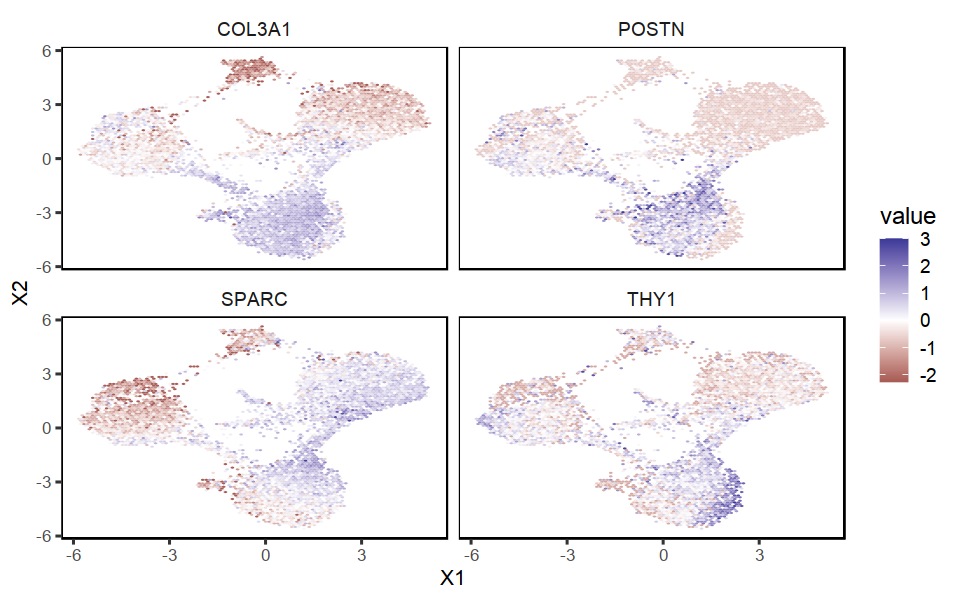

In [108]:
fig.size(5, 8)
genes_plot <- c('THY1', 'COL3A1', 'POSTN', 'SPARC')
p2 <- lung$Uh$embedding %>% 
    cbind(lung$meta_data) %>% 
    cbind(t(scaleData(lung$exprs_norm[genes_plot, ], thresh = 3))) %>% 
    data.frame() %>% 
    tidyr::gather(key, val, one_of(genes_plot)) %>% 
    ggplot(aes(X1, X2, z = val))  + 
        stat_summary_hex(fun = 'mean', bins = 100) + 
        facet_wrap(~key) + 
        scale_fill_gradient2() + 
        NULL
p2

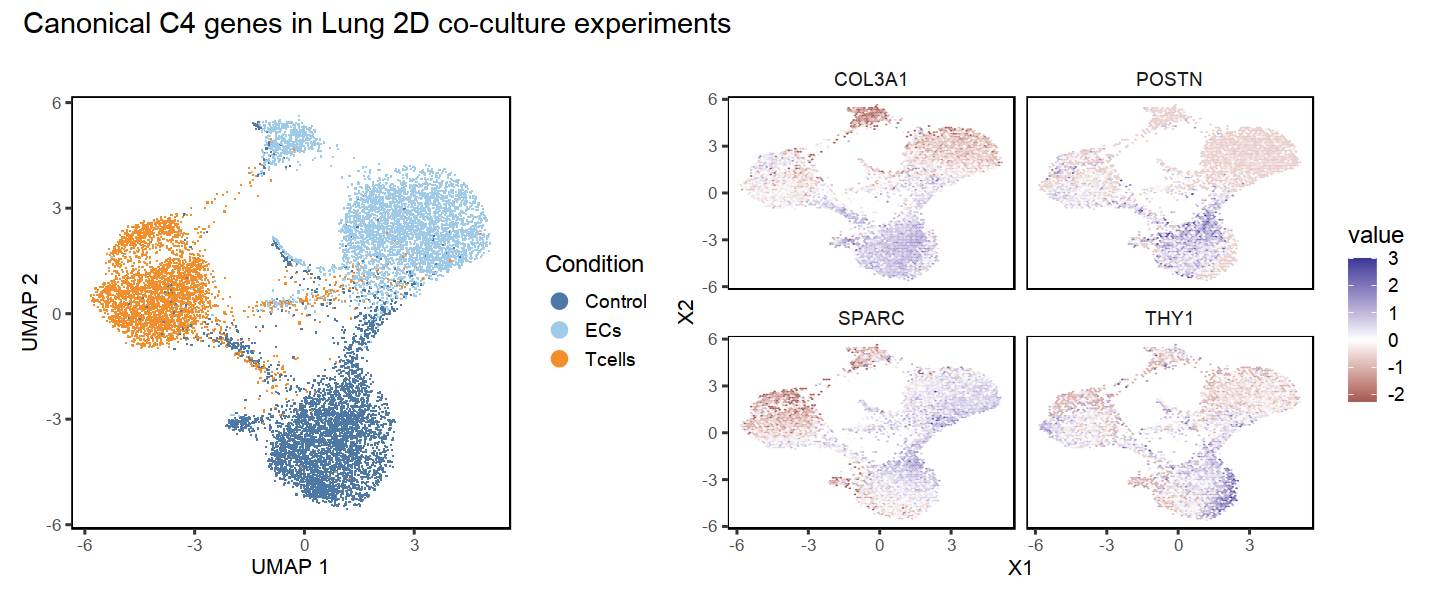

In [109]:
fig.size(5, 12)

(p1 | p2) + plot_layout(widths = c(1.5, 2)) + 
plot_annotation(title = 'Canonical C4 genes in Lung 2D co-culture experiments')

### Enrich signatures

In [48]:
## Lung C4 signature appears to be higher in controls, not with ECs
lung$enrich <- singlecellmethods:::enrich_cells(lung$exprs_norm, gs_lung, mode = 'weighted')$scores



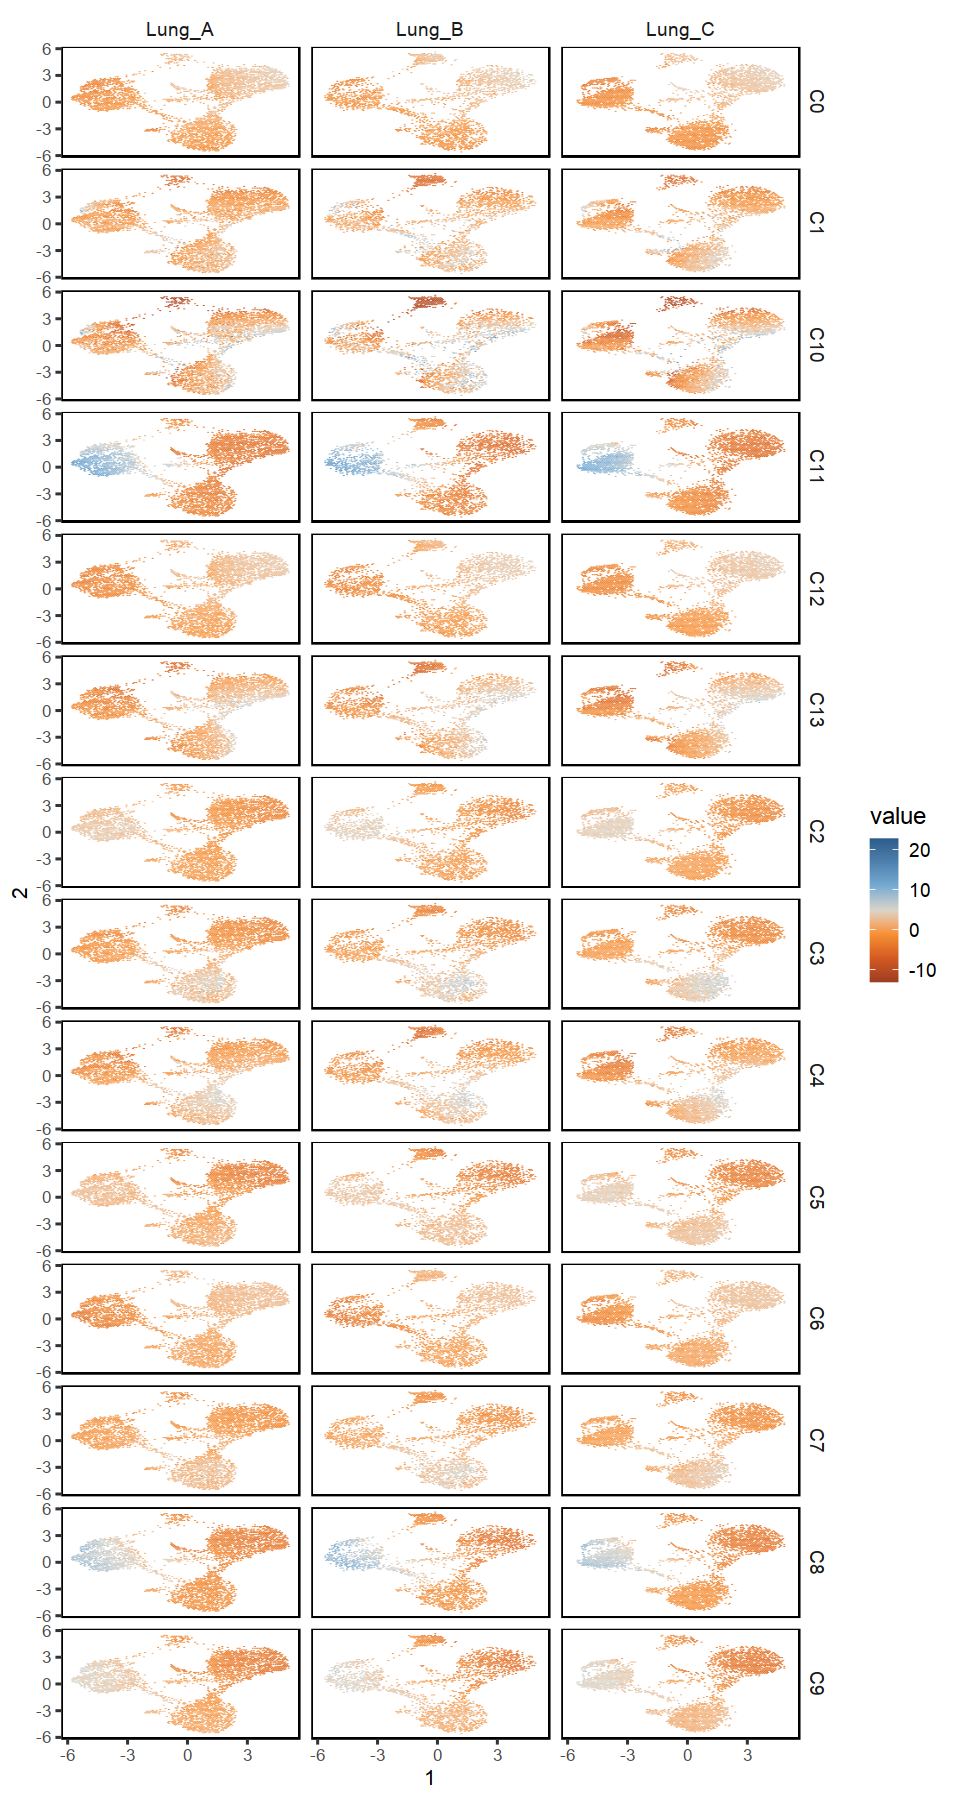

In [49]:
fig.size(15, 8)
# fig.size(8, 8)
lung$Uh$embedding %>% 
    cbind(lung$meta_data) %>% 
#     cbind(scale(lung$enrich)) %>% 
    cbind(lung$enrich) %>% 
    tidyr::gather(key, val, one_of(colnames(lung$enrich))) %>%
#     dplyr::mutate(val = pmin(val, 5)) %>% 
#     dplyr::mutate(val = pmax(val, -5)) %>% 
#     subset(key %in% paste0('C', c(0, 4, 11))) %>% 
    ggplot(aes(`1`, `2`, z = val)) + 
        stat_summary_hex(fun = 'mean', bins = 100) + 
        facet_grid(key~DonorID) + 
        scale_fill_gradient2_tableau() + 
        NULL



### Cache

In [50]:
saveRDS(lung, '/data/srlab/ik936/Roche/data/cache/revision1_stim_object_lung.rds')

# Get Signatures



## Diff exp 

Let's just do DESeq2 to do a bunch of comparisons quickly. 


In [134]:
library(DESeq2)
library(BiocParallel)

## Lung

In [135]:
lung_pb <- presto::collapse_counts(lung$exprs_raw, lung$meta_data, c('DonorID', 'Condition'))

CAREFUL: get_norm makes very strong assumptions about data



In [ ]:
register(MulticoreParam(20))

m <- lung_pb$meta_data %>% 
    subset(Condition %in% c('ECs', 'Control')) %>% 
    dplyr::mutate(Condition = factor(Condition, c('Control', 'ECs')))
ddres_ecs <- DESeqDataSetFromMatrix(
    countData = lung_pb$counts_mat[, rownames(m)],
    colData = m,
    design = ~1+Condition+DonorID
) %>% 
    DESeq(
        parallel=TRUE, 
        betaPrior=TRUE, 
        sfType='poscounts' ## necessary when some genes have 0 count
    ) %>% 
#     results(name = 'Condition_ECs_vs_Control') %>% ## betaPrior=FALSE
    results(c('Condition', 'ECs', 'Control')) %>% ## betaPrior=TRUE
    data.frame() %>% 
    tibble::rownames_to_column('feature') %>% 
    dplyr::bind_rows() %>% 
    dplyr::select(feature, everything()) %>% 
    arrange(-stat)

m <- lung_pb$meta_data %>% 
    subset(Condition %in% c('Tcells', 'Control')) %>% 
    dplyr::mutate(Condition = factor(Condition, c('Control', 'Tcells')))
ddobj_tcells <- DESeqDataSetFromMatrix(
    countData = lung_pb$counts_mat[, rownames(m)],
    colData = m,
    design = ~1+Condition+DonorID
) %>% 
    DESeq(
        parallel=TRUE, 
        betaPrior=TRUE, ## Fewer false positives with shrinkage 
        sfType='poscounts' ## necessary when some genes have 0 count
    ) %>% 
#     results(name = 'Condition_Tcells_vs_Control') %>% ## betaPrior=FALSE
    results(c('Condition', 'Tcells', 'Control')) %>% ## betaPrior=TRUE
    data.frame() %>% 
    tibble::rownames_to_column('feature') %>% 
    dplyr::bind_rows() %>% 
    dplyr::select(feature, everything()) %>% 
    arrange(-stat)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 20 workers



In [ ]:
ddres_lung <- bind_rows(list(ECs=ddres_ecs, Tcells=ddres_tcells), .id = 'Condition')

In [155]:
head(ddres_lung)

Condition feature baseMean   log2FoldChange lfcSE     stat     pvalue      
1 ECs       IGFBP2    7830.294 3.037974       0.1660071 18.30027 8.233758e-75
2 ECs       HMGA1    19578.226 2.405340       0.1333524 18.03748 9.895786e-73
3 ECs       FN1     195182.377 2.174456       0.1445121 15.04688 3.619059e-51
4 ECs       GLUL      6853.217 2.120167       0.1429024 14.83647 8.511291e-50
5 ECs       GAL       3313.980 2.415494       0.1630483 14.81459 1.179047e-49
6 ECs       HMGA2     1890.711 2.274261       0.1537905 14.78804 1.749712e-49
  padj        
1 2.393224e-71
2 2.054507e-69
3 2.921988e-48
4 6.184730e-47
5 8.159568e-47
6 1.155844e-46

## FLS

In [157]:
fls_pb <- presto::collapse_counts(fls$exprs_raw, fls$meta_data, c('DonorID', 'Condition'))

CAREFUL: get_norm makes very strong assumptions about data



In [159]:
register(MulticoreParam(20))

m <- fls_pb$meta_data %>% 
    subset(Condition %in% c('ECs', 'Control')) %>% 
    dplyr::mutate(Condition = factor(Condition, c('Control', 'ECs')))
ddres_ecs <- DESeqDataSetFromMatrix(
    countData = fls_pb$counts_mat[, rownames(m)],
    colData = m,
    design = ~1+Condition+DonorID
) %>% 
    DESeq(
        parallel=TRUE, 
        betaPrior=FALSE, 
        sfType='poscounts' ## necessary when some genes have 0 count
    ) %>% 
#     results(name = 'Condition_ECs_vs_Control') %>% ## betaPrior=FALSE
    results(c('Condition', 'ECs', 'Control')) %>% ## betaPrior=TRUE
    data.frame() %>% 
    tibble::rownames_to_column('feature') %>% 
    dplyr::bind_rows() %>% 
    dplyr::select(feature, everything()) %>% 
    arrange(-stat)

m <- fls_pb$meta_data %>% 
    subset(Condition %in% c('Tcells', 'Control')) %>% 
    dplyr::mutate(Condition = factor(Condition, c('Control', 'Tcells')))
ddres_tcells <- DESeqDataSetFromMatrix(
    countData = fls_pb$counts_mat[, rownames(m)],
    colData = m,
    design = ~1+Condition+DonorID
) %>% 
    DESeq(
        parallel=TRUE, 
        betaPrior=FALSE, 
        sfType='poscounts' ## necessary when some genes have 0 count
    ) %>% 
#     results(name = 'Condition_Tcells_vs_Control') %>% ## betaPrior=FALSE
    results(c('Condition', 'Tcells', 'Control')) %>% ## betaPrior=TRUE
    data.frame() %>% 
    tibble::rownames_to_column('feature') %>% 
    dplyr::bind_rows() %>% 
    dplyr::select(feature, everything()) %>% 
    arrange(-stat)


converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 20 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 20 workers

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 20 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 20 workers



In [160]:
ddres_fls <- bind_rows(list(ECs=ddres_ecs, Tcells=ddres_tcells), .id = 'Condition')

In [161]:
head(ddres_fls)

Condition feature baseMean log2FoldChange lfcSE     stat     pvalue       
1 ECs       IGFBP2  5618.041 4.380813       0.1489800 29.40538 4.687768e-190
2 ECs       S1PR3   1070.459 3.573479       0.1866052 19.14994  9.689077e-82
3 ECs       NOTCH3  1084.259 3.266069       0.1733502 18.84087  3.491870e-79
4 ECs       ERRFI1  3167.705 3.264059       0.1740926 18.74898  1.973353e-78
5 ECs       DUSP6   1722.990 2.916591       0.1571357 18.56096  6.650267e-77
6 ECs       TFPI    4122.846 3.101188       0.1717326 18.05824  6.795362e-73
  padj         
1 6.626628e-186
2  1.712060e-78
3  5.484564e-76
4  2.789532e-75
5  8.546198e-74
6  8.004936e-70

## Compare

In [162]:
ddres <- bind_rows(list(fls = ddres_fls, lung = ddres_lung), .id = 'Tissue')

In [163]:
ddres %>% 
    subset(feature %in% c('HES1', 'HEY1')) %>% 
    arrange(-stat)

Tissue Condition feature baseMean   log2FoldChange lfcSE     stat      
1 fls    ECs       HES1    495.769794  3.4672062     0.2350847 14.7487537
2 fls    ECs       HEY1     53.421244  3.9573798     0.6542075  6.0491199
3 lung   ECs       HES1     47.827344  0.5527010     0.3615893  1.5285328
4 lung   ECs       HEY1      5.458959  0.7395630     0.4893831  1.5112149
5 lung   Tcells    HEY1      2.699409  0.3326403     0.5970952  0.5570976
6 fls    Tcells    HEY1      5.516298  0.1726305     1.1369060  0.1518423
7 fls    Tcells    HES1     57.385186 -0.5885026     0.3416078 -1.7227434
8 lung   Tcells    HES1     19.064301 -1.0268065     0.4923969 -2.0853230
  pvalue       padj        
1 3.133989e-49 1.080538e-46
2 1.456393e-09 2.666783e-08
3 1.263803e-01 2.793862e-01
4 1.307337e-01           NA
5 5.774607e-01           NA
6 8.793113e-01 9.306410e-01
7 8.493494e-02 1.806875e-01
8 3.703999e-02 1.077245e-01

In [164]:
ddres %>% 
    subset(Condition == 'ECs') %>% 
#     subset(Condition == 'Tcells') %>% 
    split(.$Tissue) %>% 
    map(arrange, -stat) %>% 
    map(dplyr::select, -Tissue, -Condition) %>% 
    map(head, 10)

$fls
   feature  baseMean log2FoldChange     lfcSE     stat        pvalue
1   IGFBP2  5618.041       4.380813 0.1489800 29.40538 4.687768e-190
2    S1PR3  1070.459       3.573479 0.1866052 19.14994  9.689077e-82
3   NOTCH3  1084.259       3.266069 0.1733502 18.84087  3.491870e-79
4   ERRFI1  3167.705       3.264059 0.1740926 18.74898  1.973353e-78
5    DUSP6  1722.990       2.916591 0.1571357 18.56096  6.650267e-77
6     TFPI  4122.846       3.101188 0.1717326 18.05824  6.795362e-73
7     PGK1  8047.069       2.208066 0.1275129 17.31641  3.537290e-67
8    ITGA5  6127.534       2.885112 0.1708792 16.88393  5.907865e-64
9   AKAP12 12130.404       2.024872 0.1220364 16.59235  7.915655e-62
10  DCBLD2  5734.532       2.360143 0.1433176 16.46792  6.238127e-61
            padj
1  6.626628e-186
2   1.712060e-78
3   5.484564e-76
4   2.789532e-75
5   8.546198e-74
6   8.004936e-70
7   3.125196e-64
8   4.639643e-61
9   5.328367e-59
10  3.391622e-58

$lung
   feature   baseMean log2FoldChange     lfcSE     stat       pvalue
1   IGFBP2   7830.294       3.037974 0.1660071 18.30027 8.233758e-75
2    HMGA1  19578.226       2.405340 0.1333524 18.03748 9.895786e-73
3      FN1 195182.377       2.174456 0.1445121 15.04688 3.619059e-51
4     GLUL   6853.217       2.120167 0.1429024 14.83647 8.511291e-50
5      GAL   3313.980       2.415494 0.1630483 14.81459 1.179047e-49
6    HMGA2   1890.711       2.274261 0.1537905 14.78804 1.749712e-49
7     MT2A 170459.809       1.935163 0.1329467 14.55593 5.354876e-48
8      MYC   2262.876       2.198539 0.1543961 14.23960 5.202097e-46
9    SPRY2   1046.890       2.225578 0.1661069 13.39847 6.172050e-41
10    TUT7   1960.230       1.845463 0.1430700 12.89902 4.558653e-38
           padj
1  2.393224e-71
2  2.054507e-69
3  2.921988e-48
4  6.184730e-47
5  8.159568e-47
6  1.155844e-46
7  2.993170e-45
8  2.438776e-43
9  2.718134e-38
10 1.840303e-35

In [165]:
genes_ecs_shared <- ddres %>% 
    subset(padj < .01) %>% 
    dplyr::select(Tissue, Condition, SCORE=stat, feature) %>% 
#     dplyr::select(Tissue, Condition, SCORE=log2FoldChange, feature) %>% 
    tidyr::spread(Tissue, SCORE, fill = 0) %>% 
    subset(fls > 0 & lung > 0) %>% 
    arrange(-fls * lung) %>% 
    subset(Condition == 'ECs') %>% 
    head(20) %>% 
    with(feature)
#     split(.$Condition) %>% 
#     map(arrange, -fls * lung) %>% 
#     map(head, 10) 


In [166]:
effects_nested %>% 
    subset(Tissue == 'Synovium') %>% 
#     subset(Tissue == 'Lung') %>% 
    subset(feature %in% genes_ecs_shared) %>% 
    subset(pvalue < .05) %>% 
    arrange(-zscore)

contrast    Cluster Tissue   feature beta      sigma     zscore  
1  9|Synovium  9       Synovium AKAP12  1.7186287 0.3220120 5.337157
2  6|Synovium  6       Synovium ERRFI1  1.3578689 0.3344084 4.060510
3  3|Synovium  3       Synovium IGFBP2  1.7865973 0.4509393 3.961947
4  10|Synovium 10      Synovium ERRFI1  1.3668694 0.4246927 3.218491
5  5|Synovium  5       Synovium AKAP12  0.9846392 0.3063670 3.213921
6  3|Synovium  3       Synovium RAC3    1.0861785 0.3862195 2.812335
7  10|Synovium 10      Synovium MT2A    0.7553539 0.2934923 2.573675
8  13|Synovium 13      Synovium ERRFI1  1.1471163 0.4702960 2.439137
9  4|Synovium  4       Synovium RAC3    0.8848431 0.3682980 2.402519
10 13|Synovium 13      Synovium FN1     1.1033244 0.4739274 2.328045
11 10|Synovium 10      Synovium FN1     0.8670731 0.3887197 2.230587
12 0|Synovium  0       Synovium ERRFI1  1.0949023 0.4947847 2.212886
13 6|Synovium  6       Synovium MT2A    0.6146422 0.2849949 2.156678
14 8|Synovium  8       Synovium IGFBP2  1.4286527 0.7261088 1.967546
15 1|Synovium  1       Synovium FN1     0.6725195 0.3555938 1.891258
16 5|Synovium  5       Synovium IGFBP2  0.7941873 0.4238045 1.873947
17 12|Synovium 12      Synovium ERRFI1  0.9371909 0.5027696 1.864056
18 8|Synovium  8       Synovium MYC     0.7069078 0.3878060 1.822838
19 5|Synovium  5       Synovium SPRY2   0.5618315 0.3130575 1.794659
20 0|Synovium  0       Synovium HMGA1   1.1744394 0.6553082 1.792194
21 12|Synovium 12      Synovium MT2A    0.6887160 0.3899823 1.766018
22 5|Synovium  5       Synovium RAC3    0.7325553 0.4163807 1.759340
23 10|Synovium 10      Synovium HMGA2   1.0005960 0.5721084 1.748962
24 0|Synovium  0       Synovium FN1     0.6317265 0.3635590 1.737618
25 4|Synovium  4       Synovium HMGA1   0.5559879 0.3291537 1.689144
26 6|Synovium  6       Synovium FN1     0.6418539 0.3820916 1.679843
   pvalue      
1  4.720777e-08
2  2.448278e-05
3  3.717057e-05
4  6.443360e-04
5  6.546787e-04
6  2.459162e-03
7  5.031233e-03
8  7.361200e-03
9  8.141284e-03
10 9.954846e-03
11 1.285425e-02
12 1.345275e-02
13 1.551538e-02
14 2.456013e-02
15 2.929497e-02
16 3.046884e-02
17 3.115690e-02
18 3.416393e-02
19 3.635402e-02
20 3.655095e-02
21 3.869638e-02
22 3.925987e-02
23 4.014877e-02
24 4.113912e-02
25 4.559595e-02
26 4.649391e-02

`geom_smooth()` using formula 'y ~ x'



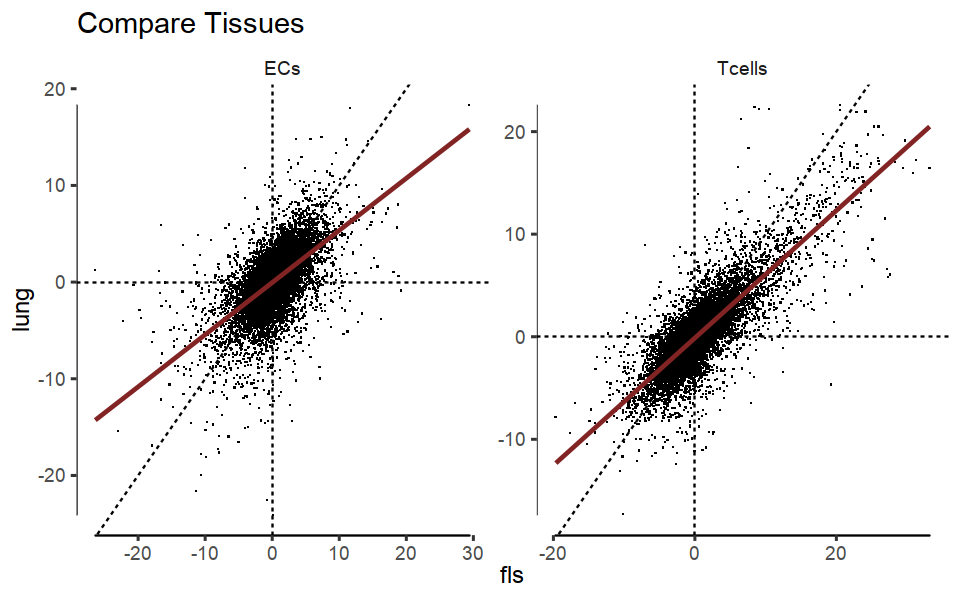

In [167]:
fig.size(5, 8)
ddres %>% 
    dplyr::select(Tissue, Condition, SCORE=stat, feature) %>% 
#     dplyr::select(Tissue, Condition, SCORE=log2FoldChange, feature) %>% 
    tidyr::spread(Tissue, SCORE, fill = 0) %>% 
    ggplot(aes(fls, lung)) +
        facet_wrap(~Condition, scales = 'free') + 
        geom_hline(yintercept = 0, linetype = 2) + 
        geom_vline(xintercept = 0, linetype = 2) + 
        geom_abline(linetype = 2) + 
        geom_point(shape = '.', position = position_jitter(height = .05, width = .05)) + 
        theme_tufte(base_size = 14) + 
        geom_smooth(method = 'lm', color = muted('red'), se = FALSE) + 
        geom_rangeframe() + 
        labs(title = 'Compare Tissues') + 
        NULL


`geom_smooth()` using formula 'y ~ x'



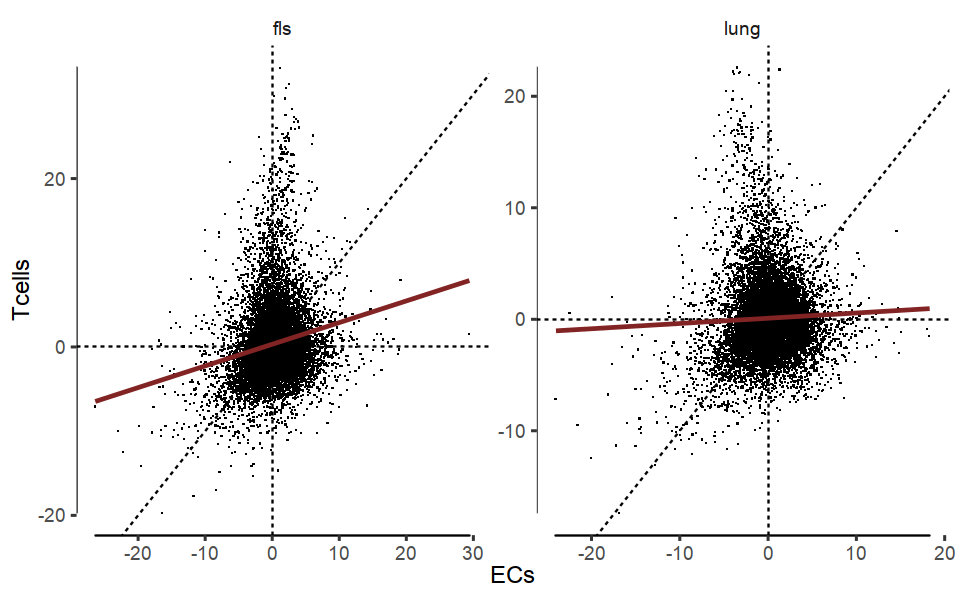

In [168]:
fig.size(5, 8)
ddres %>% 
    dplyr::select(Tissue, Condition, SCORE=stat, feature) %>% 
#     dplyr::select(Tissue, Condition, SCORE=log2FoldChange, feature) %>% 
    tidyr::spread(Condition, SCORE, fill = 0) %>% 
    ggplot(aes(ECs, Tcells)) +
        facet_wrap(~Tissue, scales = 'free') + 
        geom_hline(yintercept = 0, linetype = 2) + 
        geom_vline(xintercept = 0, linetype = 2) + 
        geom_abline(linetype = 2) + 
        geom_point(shape = '.', position = position_jitter(height = .05, width = .05)) + 
        geom_smooth(method = 'lm', color = muted('red'), se = FALSE) + 
        theme_tufte(base_size = 14) + 
        geom_rangeframe() + 
        NULL


## Compare to Cluster signatures

In [514]:
ddres %>% subset(feature == 'PI16')

Tissue Condition feature baseMean   log2FoldChange lfcSE     stat      
15983 fls    ECs       PI16    389.866426 -2.01500764    0.7552136 -2.6681296
29421 fls    Tcells    PI16    551.173496 -0.02242625    0.2012423 -0.1114391
53131 lung   ECs       PI16      4.378655 -1.34153419    1.3263768 -1.0114276
67463 lung   Tcells    PI16      5.182845  0.22889172    1.1425398  0.2003359
      pvalue      padj      
15983 0.007627483 0.02794516
29421 0.911268183 0.95178881
53131 0.311811803         NA
67463 0.841217896         NA

In [60]:
readRDS('/data/srlab/ik936/Roche/data/cache/obj_fibroblasts/effects_nested.rds') %>% head

contrast        Cluster Tissue        feature beta     sigma     zscore  
1 9|SalivaryGland 9       SalivaryGland PCOLCE2 4.163958 0.4628805 8.995752
2 9|Synovium      9       Synovium      PI16    5.731668 0.6866517 8.347271
3 13|Gut          13      Gut           MYH11   3.683069 0.4625761 7.962083
4 9|SalivaryGland 9       SalivaryGland C1QTNF3 3.890439 0.4946351 7.865272
5 5|Gut           5       Gut           OGN     2.614685 0.3343675 7.819795
6 9|SalivaryGland 9       SalivaryGland CLDN11  2.872666 0.3690599 7.783740
  pvalue      
1 1.173106e-19
2 3.492922e-17
3 8.458316e-16
4 1.841488e-15
5 2.645465e-15
6 3.520577e-15

In [65]:
.x <- readRDS('/data/srlab/ik936/Roche/data/cache/obj_fibroblasts/effects_nested.rds') %>% 
#     subset(Tissue == 'Synovium') %>% 
#     inner_join(subset(ddres, Tissue == 'fls' & Condition == 'ECs' & stat > 2), by = c('feature')) %>% 
    subset(Tissue == 'Lung') %>% 
    left_join(subset(ddres, Tissue == 'lung' & Condition == 'ECs'), by = c('feature')) 
#     dplyr::select(Cluster, beta_cluster = zscore, beta_culture = stat)

In [66]:
data.table(.x)[, broom::tidy(cor.test(~zscore + stat)), by = .(Cluster)][order(-)]

Cluster estimate     statistic   p.value       parameter conf.low     
1  9        0.083761189  10.1524199  3.888260e-24 14588      0.0676265244
2  4        0.051244812   6.1975319  5.889794e-10 14588      0.0350473759
3  11      -0.048872709  -5.9099468  3.498496e-09 14588     -0.0650477029
4  5        0.015436509   1.8646560  6.224971e-02 14588     -0.0007902682
5  8       -0.132569638 -16.1544502  3.377883e-58 14588     -0.1484768215
6  10      -0.038138837  -4.6097928  4.064895e-06 14588     -0.0543317923
7  13       0.035764738   4.3224588  1.553225e-05 14588      0.0195495041
8  3        0.007833953   0.9462201  3.440520e-01 14588     -0.0083936931
9  7       -0.025186477  -3.0430080  2.346427e-03 14588     -0.0413961385
10 6        0.028945049   3.4974714  4.710889e-04 14588      0.0127244462
11 2        0.079426315   9.6235767  7.383519e-22 14588      0.0632812933
12 12       0.152720713  18.6646770  7.521537e-77 14588      0.1368332250
13 1       -0.256705435 -32.0801001 2.932253e-218 14588     -0.2717998452
14 0        0.196017978  24.1435851 2.585378e-126 14588      0.1803650858
   conf.high    method                               alternative
1   0.099852053 Pearson's product-moment correlation two.sided  
2   0.067415334 Pearson's product-moment correlation two.sided  
3  -0.032672040 Pearson's product-moment correlation two.sided  
4   0.031655159 Pearson's product-moment correlation two.sided  
5  -0.116593870 Pearson's product-moment correlation two.sided  
6  -0.021925827 Pearson's product-moment correlation two.sided  
7   0.051961162 Pearson's product-moment correlation two.sided  
8   0.024057474 Pearson's product-moment correlation two.sided  
9  -0.008963561 Pearson's product-moment correlation two.sided  
10  0.045150422 Pearson's product-moment correlation two.sided  
11  0.095529774 Pearson's product-moment correlation two.sided  
12  0.168529653 Pearson's product-moment correlation two.sided  
13 -0.241484748 Pearson's product-moment correlation two.sided  
14  0.211571611 Pearson's product-moment correlation two.sided

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1890 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1890 rows containing missing values (geom_point).”


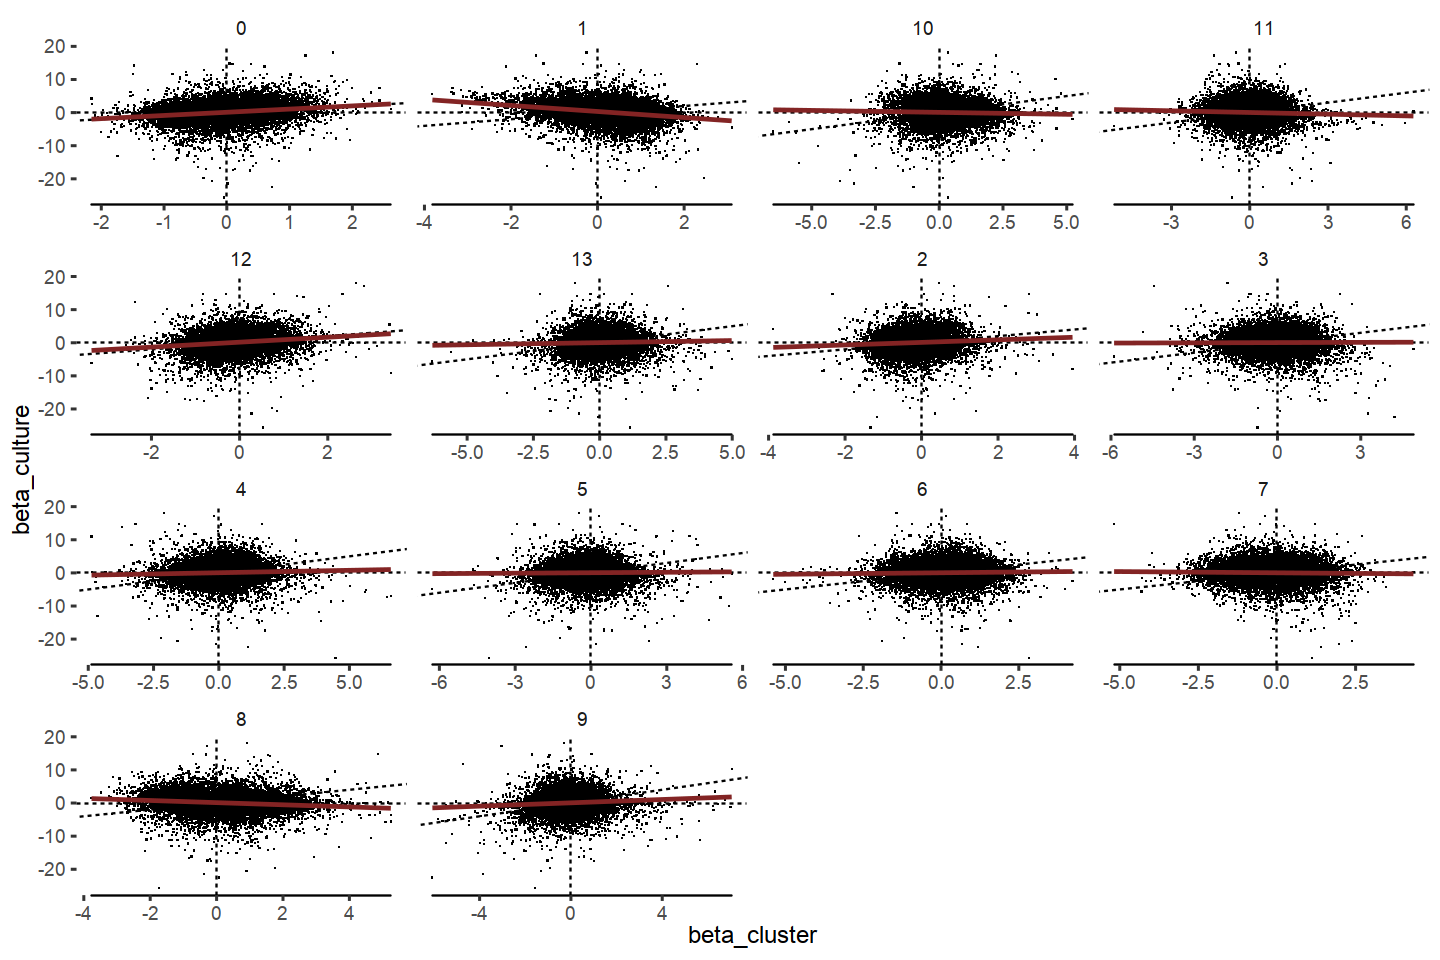

In [61]:
fig.size(20, 12)
readRDS('/data/srlab/ik936/Roche/data/cache/obj_fibroblasts/effects_nested.rds') %>% 
#     subset(Tissue == 'Synovium') %>% 
#     inner_join(subset(ddres, Tissue == 'fls' & Condition == 'ECs' & stat > 2), by = c('feature')) %>% 
    subset(Tissue == 'Lung') %>% 
    left_join(subset(ddres, Tissue == 'lung' & Condition == 'ECs'), by = c('feature')) %>% 
    dplyr::select(Cluster, beta_cluster = zscore, beta_culture = stat) %>% 
#     dplyr::select(Cluster, beta_cluster = beta, beta_culture = log2FoldChange) %>% 
    ggplot(aes(beta_cluster, beta_culture)) + 
        geom_point(shape = '.') + 
        facet_wrap(~Cluster, scales = 'free_x') + 
        geom_hline(yintercept = 0, linetype = 2) + 
        geom_vline(xintercept = 0, linetype = 2) + 
        geom_abline(linetype = 2) + 
        geom_smooth(method = 'lm', color = muted('red'), se = FALSE) + 
        theme_tufte(base_size = 14) + 
        geom_rangeframe() + 
        NULL


Picking joint bandwidth of 0.223

Warning message:
“Removed 51 rows containing non-finite values (stat_density_ridges).”
Picking joint bandwidth of 0.177

Warning message:
“Removed 127 rows containing non-finite values (stat_density_ridges).”


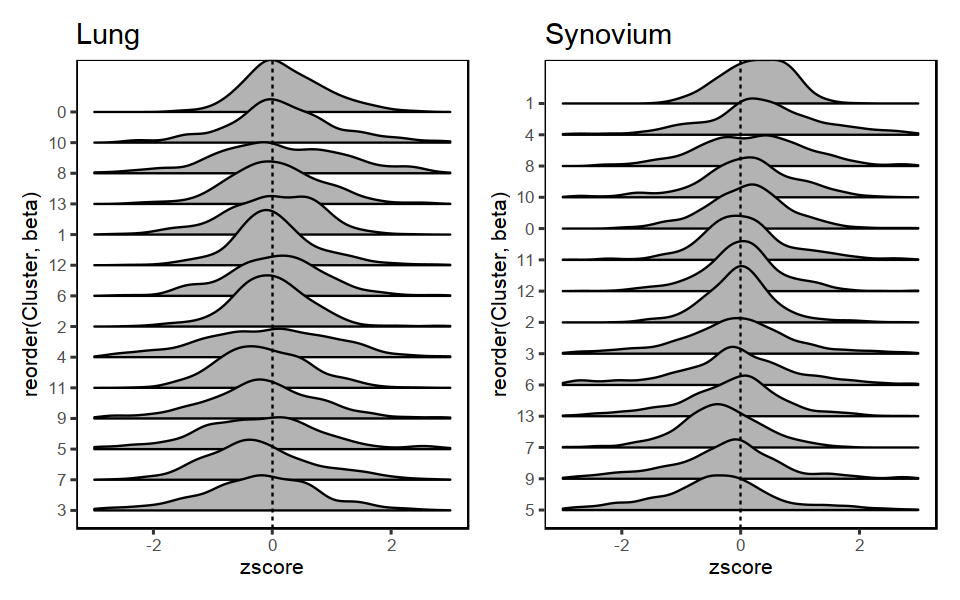

In [544]:
## Conditional analysis: 
## Of the genes that went up in cultue, they are overall pretty highly expressed in C4 
fig.size(5, 8)
readRDS('/data/srlab/ik936/Roche/data/cache/obj_fibroblasts/effects_nested.rds') %>% 
#     subset(Tissue %in% 'Synovium') %>% 
    inner_join(
        ddres %>% 
#             subset(, Tissue == 'fls' & Condition == 'ECs' & padj < .05 & log2FoldChange > 1), 
            subset(Condition == 'ECs' & padj < .05 & log2FoldChange > 1) %>% 
            dplyr::mutate(Tissue = c(fls='Synovium', lung='Lung')[Tissue]),
        by = c('feature', 'Tissue')
    ) %>% 
    split(.$Tissue) %>% 
    imap(function(.SD, .tissue) {
#         ggplot(.SD, aes(beta, reorder(Cluster, beta))) + 
        ggplot(.SD, aes(zscore, reorder(Cluster, beta))) + 
            geom_density_ridges2() + 
            geom_vline(xintercept = 0, linetype = 2) + 
            labs(title = .tissue) + 
            xlim(-3, 3) + 
            NULL
    }) %>% 
    purrr::reduce(`+`) 


## Cache

In [169]:
saveRDS(ddres, '/data/srlab/ik936/Roche/data/cache/stim_revisions_ddres_v1.rds')

In [58]:
ddres <- readRDS('/data/srlab/ik936/Roche/data/cache/stim_revisions_ddres_v1.rds')

# Compare to 3D micromass

## Load data 

In [3]:
mm <- readRDS('/data/srlab/ik936/NOTCH/data/cache/analysis_sc_mm3.rds')
counts <- readRDS('/data/srlab/ik936/NOTCH/data/cache/exprs_raw_sc2.rds')
mm$counts <- counts[, mm$meta_data$cell_id]

## Compute signature

In [6]:
library(DESeq2)
library(BiocParallel)

In [10]:
unique(mm$meta_data$label)
unique(mm$meta_data$donor)

[1] "FLS_HUVEC_DAPT" "FLS"            "FLS_HUVEC"

[1] "BRI499_8" "BRI499_7" "BRI499_1" "BRI499_3" "BRI499_6" "BRI499_2" "BRI499_9"
[8] "BRI499_4" "BRI499_5"

In [38]:
head(mm$meta_data)

cell_id              donor    nUMI  nGene percent_mito label          status
1 AAACCCAAGTGATAGT_mm3 BRI499_8  1744  845  0.10149083   FLS_HUVEC_DAPT case  
2 AAACCCAAGTTAGAAC_mm3 BRI499_7 13278 3370  0.10604007   FLS_HUVEC_DAPT case  
3 AAACCCAAGTTTCGGT_mm3 BRI499_1  8931 2264  0.19157989   FLS            case  
4 AAACCCACAGGGAATC_mm3 BRI499_3  4661 1713  0.10898949   FLS            case  
5 AAACCCAGTAAGATTG_mm3 BRI499_6  4825 1783  0.04704663   FLS_HUVEC      case  
6 AAACCCAGTACTTGTG_mm3 BRI499_2  3884 1451  0.10530381   FLS            case  
  cell_type  time      time_pca score_notch
1 fibroblast  70.89613 45.02241 15.25729   
2 fibroblast  20.80471 98.40403 21.34137   
3 fibroblast  85.14724 15.48469 24.54415   
4 fibroblast  94.18567 25.49295 21.40701   
5 fibroblast  82.31336 17.28643 24.85732   
6 fibroblast 100.00000 38.35235 21.88630

In [47]:
.m <- mm$meta_data %>% subset(label %in% c('FLS', 'FLS_HUVEC'))
pb <- presto::collapse_counts(mm$counts[, .m$cell_id], .m, c('donor', 'label'))

CAREFUL: get_norm makes very strong assumptions about data



In [49]:
pb$meta_data

donor    label     N    logUMI  
sample_0  BRI499_1 FLS       3323 16.55792
sample_2  BRI499_3 FLS       2448 16.26909
sample_11 BRI499_6 FLS_HUVEC  989 15.83799
sample_1  BRI499_2 FLS       3501 16.63186
sample_9  BRI499_4 FLS_HUVEC  672 15.41345
sample_10 BRI499_5 FLS_HUVEC 1112 15.89922

In [51]:
register(MulticoreParam(20))

m <- pb$meta_data %>% 
    dplyr::mutate(label = factor(label, c('FLS', 'FLS_HUVEC')))
ddres <- DESeqDataSetFromMatrix(
    countData = pb$counts_mat[, rownames(m)],
    colData = m,
    design = ~1+label
) %>% 
    DESeq(
        parallel=TRUE, 
        betaPrior=TRUE, 
        sfType='poscounts' ## necessary when some genes have 0 count
    ) %>% 
#     results(name = 'Condition_ECs_vs_Control') %>% ## betaPrior=FALSE
    results(c('label', 'FLS_HUVEC', 'FLS')) %>% ## betaPrior=TRUE
    data.frame() %>% 
    tibble::rownames_to_column('feature') %>% 
    dplyr::bind_rows() %>% 
    dplyr::select(feature, everything()) %>% 
    arrange(-stat)


converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates: 20 workers

mean-dispersion relationship

final dispersion estimates, MLE betas: 20 workers

fitting model and testing: 20 workers



In [52]:
head(ddres)

feature baseMean  log2FoldChange lfcSE      stat     pvalue padj
1 COL3A1  25220.652 5.002895       0.05748340 87.03200 0      0   
2 IGFBP7   4256.958 4.018324       0.05423130 74.09603 0      0   
3 COL4A1   3302.325 3.784767       0.05672943 66.71612 0      0   
4 BGN      6105.515 3.368662       0.05096730 66.09457 0      0   
5 SPARC   11361.454 2.473261       0.03925548 63.00421 0      0   
6 OLFM2    2036.874 4.414150       0.07172393 61.54362 0      0

## Cache

In [53]:
saveRDS(ddres, '/data/srlab/ik936/Roche/data/cache/micromass_deseq2.rds')